# Final Project
Syracuse Applied Data Science, IST-718 Big Data Analytics  

Team: AUQ-42
Team Members:
* Ryan Timbrook
* Amanda Carvalho
* Luigi Penaloza
* Chikeung Cheung

DATE:   
ASSIGNMENT: IEEE-CIS Fraud Detection (kaggle competition)


## Business Question
Improve the efficacy of fraudulent transaction alerts, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue; while securing consumer’s peace of mind and wallets!





## Problems to solve
Identify real-time fraudulent e-commerce transactions, using advanced Machine Learning algorithms, by automating alerts that block highly suspicious activities. 

## Why the problem is important
Everyone who uses e-commerce technology and modern banking systems are at risk of being a victim of fraud. It costs both the individual as well as the merchant who offers refunds for fraudulent transactions; and not all scenarios are covered, leaving many individuals having to pay.  

Chargebacks area a growing costly burden for merchants. By eliminating chargebacks, fines, and fees related to third-party fraud and unauthorized charges, the client, VESTA , is able to significantly reduce the operational costs and resources associated with complex chargeback management solutions and the specialized staff necessary for rapid, scalable business growth. This leaves all the cost risk on the client. Improving automated fraudulent detection technology will greatly reduce this cost.  
 

# About the Data
The core data set for this project is provided by VESTA, the worlds leading payment service company, and is a kaggle competition being facilitated by the [IEEE Computational Intelligence Society](https://www.kaggle.com/c/ieee-fraud-detection/data).

## [VESTA](https://www.kaggle.com/c/ieee-fraud-detection/data)
Predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.  

The data is broken into two files identity and transaction, which are joined by **TransactionID**. *Not all transactions have corresponding identity information.*

#### Categorical Features - Transaction
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

#### Categorical Features - Identity
* DeviceType
* DeviceInfo
* id_12 - id_38

*The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).*

##### Files
* train_{transaction, identity}.csv - the training set
* test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
* sample_submission.csv - a sample submission file in the correct format

## CCFD (kaggel)



## FTC

### --------------------------------------------------------------------------------------------
## Coding Environment Setup

In [9]:
# toggle for working with colab
isColab = False

# ONLY RUN WHEN WORKING ON COLAB

In [ ]:
# mount google drive for working in colab
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST718_PRJ_FraudDetection/workspace/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
 # print(f'file name: {f}')

#isColab = True

**==============================================================================================**

In [10]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions

import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns #

import warnings
warnings.filterwarnings('ignore')

import timeit # for performance debugging
import logging
logging.getLogger('tensorflow').disabled = True

pd.set_option('display.max_rows', 500)
pd.get_option("display.max_columns",500)

20

In [11]:
# import custome packages
import auq_42_utils as auq

All the files are downloaded


In [12]:
# set global properties
if not isColab:
    dataDir = './data/'
    outputDir = './output/'
    configDir = './config/'
    logOutDir = './logs/'
    imageDir = './images/'
    modelDir = './models/'
else:
    # working within colab
    dataDir = f'{base_dir}/data/'
    outputDir = f'{base_dir}/output/'
    configDir = f'{base_dir}/config/'
    logOutDir = f'{base_dir}/logs/'
    imageDir = f'{base_dir}/images/'
    modelDir = f'{base_dir}/models/'

In [13]:
# get a logger for troubleshooting / data exploration
appName = 'rt_fraud_explore' # sets the logger file name
loglevel = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL
logger = auq.getFileLogger(logOutDir,appName,level=loglevel)

### Vesta Dataset
#### IEEE-CIS Fraud Detection
##### Can you detect fraud from customer transactions?
* kaggle [link](https://www.kaggle.com/c/ieee-fraud-detection/data)

### Credit Card Fraud Detection
#### Anonymized credit card transactions labeled as fraudulent or genuine
* Kaggel [Link](https://kaggle.com/mlg-ulb/creditcardfraud)

In [14]:
# read in datasets
import pickle
# look for reduced memory dataset first
isMemoryReductionTrain = False
isMemoryReductionTest = False

# training datasets
try:
    with open(f'{dataDir}v_train.pkl','rb') as f:
        v_train = pickle.load(f)
        logger.info(f'saved pickled vesta train dataset found...')
        isMemoryReductionTrain = True
except FileNotFoundError:
    logger.info('v_train file not found... pulling data in from csv files')
    # VESTA
    v_train_identity = pd.read_csv(f'{dataDir}ieee_train_identity.csv')
    v_train_transaction = pd.read_csv(f'{dataDir}ieee_train_transaction.csv')
    # merge VESTA training datasets
    v_train = pd.merge(v_train_transaction, v_train_identity, on='TransactionID', how='left') 
    # free up memory of loaded datasets after merging
    v_train_identity = None
    v_train_transaction = None

# testing datasets
try:
    with open(f'{dataDir}v_test.pkl','rb') as f:
        v_test = pickle.load(f)
        logger.info(f'saved pickled vesta testing dataset found...')
        isMemoryReductionTest = True
except FileNotFoundError:
    logger.info('v_test file not found... pulling data in from csv files')
    v_test_identity = pd.read_csv(f'{dataDir}ieee_test_identity.csv')
    v_test_transaction = pd.read_csv(f'{dataDir}ieee_test_transaction.csv')
    # merge test datasets
    v_test = pd.merge(v_test_transaction, v_test_identity, on='TransactionID', how='left')
    # free up memory of loaded datasets after merging
    v_test_identity = None
    v_test_transaction = None


saved pickled vesta train dataset found...
saved pickled vesta testing dataset found...


In [15]:
# look at the datasets shaped
logger.info(f'Vesta Train dataset shape: [{v_train.shape}]')
logger.info(f'Vesta Test dataset shape: [{v_test.shape}]')
logger.info(f'Vesta Train dataset Total NAN count: [{auq.getNaNCount(v_train)[0]}]')
logger.info(f'Vesta Test dataset Total NAN count: [{auq.getNaNCount(v_test)[0]}]')

Vesta Train dataset shape: [(590540, 434)]
Vesta Test dataset shape: [(506691, 433)]
Vesta Train dataset Total NAN count: [115523073]
Vesta Test dataset Total NAN count: [90186908]


In [16]:
# which columns have NaN fields, and how many are there
logger.info(f'Vesta Train dataset column NANs {auq.getColumnsNaNCnts(v_train, logger)}')

Vesta Train dataset column NANs [('card2', 8933), ('card3', 1565), ('card4', 1577), ('card5', 4259), ('card6', 1571), ('addr1', 65706), ('addr2', 65706), ('dist1', 352271), ('dist2', 552913), ('P_emaildomain', 94456), ('R_emaildomain', 453249), ('D1', 1269), ('D2', 280797), ('D3', 262878), ('D4', 168922), ('D5', 309841), ('D6', 517353), ('D7', 551623), ('D8', 515614), ('D9', 515614), ('D10', 76022), ('D11', 279287), ('D12', 525823), ('D13', 528588), ('D14', 528353), ('D15', 89113), ('M1', 271100), ('M2', 271100), ('M3', 271100), ('M4', 281444), ('M5', 350482), ('M6', 169360), ('M7', 346265), ('M8', 346252), ('M9', 346252), ('V1', 279287), ('V2', 279287), ('V3', 279287), ('V4', 279287), ('V5', 279287), ('V6', 279287), ('V7', 279287), ('V8', 279287), ('V9', 279287), ('V10', 279287), ('V11', 279287), ('V12', 76073), ('V13', 76073), ('V14', 76073), ('V15', 76073), ('V16', 76073), ('V17', 76073), ('V18', 76073), ('V19', 76073), ('V20', 76073), ('V21', 76073), ('V22', 76073), ('V23', 76073),

## SCRUB / CLEAN
Clean and perform initial transformations steps of the data

### Run Memory Reduction Pre-Processing
**Session memory after loading datasets was 11 GB. After running memory reduction steps it's 1.3 GB   

**This was completed in notebook fraud-obtain-data** use that notebook for reference

In [17]:
# run memory reduction
if not isMemoryReductionTrain:
    logger.info(f'Before Reduction Memory Usage: VESTA Training Dataset:[{auq.mem_usage(v_train)}]')
    v_train = auq.reduce_df_memory(v_train, logger)
    auq.save_df(v_train, f'{dataDir}v_train.pkl', logger)
    logger.info(f'After Reduction Memory Usage: VESTA Training Dataset:[{auq.mem_usage(v_train)}]')
if not isMemoryReductionTest:
    logger.info(f'Before Reduction Memory Usage: VESTA Testing Dataset: [{auq.mem_usage(v_test)}]')
    v_test = auq.reduce_df_memory(v_test, logger)
    auq.save_df(v_test, f'{dataDir}v_test.pkl', logger)
    logger.info(f'After Reduction Memory Usage: VESTA Testing Dataset: [{auq.mem_usage(v_test)}]')

## EXPLORE
Explore the datasets

In [18]:
# perform exploratory data analysis techiques
logger.info(v_train.columns)
logger.info(v_train.head())
logger.info(v_test.head())

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=434)
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  

In [19]:
logger.info(v_train.info())
print('')
logger.info(v_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 530.0 MB


None



<class 'pandas.core.frame.DataFrame'>
Int64Index: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(346), float32(53), int16(1), int32(2)
memory usage: 462.0 MB


None


In [20]:
for col, values in v_train.iteritems():
    num_uniques = values.nunique()
    logger.info('{name}: {num_unique}'.format(name=col, num_unique=num_uniques))
    logger.info(values.unique())
    print('\n')

TransactionID: 590540
[2987000 2987001 2987002 ... 3577537 3577538 3577539]


isFraud: 2
[0 1]


TransactionDT: 573349
[   86400    86401    86469 ... 15811079 15811088 15811131]


TransactionAmt: 8195
[  68.5     29.      59.    ... 1731.     174.125 1660.   ]


ProductCD: 5
[W, H, C, S, R]
Categories (5, object): [W, H, C, S, R]


card1: 13553
[13926  2755  4663 ... 13166  8767 18038]


card2: 500
[ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 583. 148. 321. 269. 361. 272. 399. 569. 453. 417. 512. 545. 266.
 114. 481. 452. 547. 383. 170. 343. 556. 285. 562. 302. 264. 558. 500.
 396. 103. 206. 143. 243. 476. 199. 174. 423. 446. 492. 523. 440. 528.
 161. 535. 354. 117. 455. 325. 158. 268. 122. 479. 147. 215. 480. 265.
 388. 408. 309. 415. 414. 437. 104. 225. 101. 134. 586. 191. 491. 369.
 322. 494. 532. 313. 474. 324. 475. 298. 429. 432. 553. 566. 599. 296.
 251. 310. 242. 204. 250. 270. 346. 316. 194. 587. 390. 135. 536. 254.
 226. 327. 420. 260. 413. 428. 561. 387. 411. 392. 203. 297. 136. 276.
 142. 527. 210. 184. 459. 118. 585. 106. 588. 449. 176. 177. 246. 439.
 503. 445. 172. 468. 239. 496. 364. 533. 370. 578. 150. 458. 365. 359.
 509. 202. 584. 258. 442. 530. 489. 529. 504. 356. 123. 205. 130. 382.
 155. 105. 422. 345. 257. 171. 559. 271. 554. 127. 236. 548. 454. 373.
 275. 286. 308. 517. 294. 145. 565. 245. 513. 520. 133. 162. 163. 

card3: 114
[150. 117. 185. 143. 144. 163. 146. 191. 162. 119. 147. 100. 135. 137.
 138. 102. 213. 106. 214. 148. 210. 203. 194. 141. 225.  nan 188. 193.
 208. 133. 223. 134. 153. 131. 200. 149. 116. 222. 220. 197. 129. 206.
 195. 204. 127. 142. 111. 159. 118. 229. 217. 212. 227. 166. 189. 120.
 171. 190. 105. 130. 170. 180. 177. 132. 109. 198. 121. 183. 215. 156.
 207. 186. 167. 152. 199. 219. 202. 126. 182. 123. 107. 221. 124. 231.
 157. 136. 128. 168. 101. 108. 125. 211. 164. 160. 161. 179. 155. 169.
 205. 209. 226. 174. 176. 181. 224. 122. 201. 175. 139. 172. 114. 228.
 184. 151. 173.]


card4: 4
[discover, mastercard, visa, american express, NaN]
Categories (4, object): [discover, mastercard, visa, american express]


card5: 119
[142. 102. 166. 117. 226. 224. 134. 219. 137. 195. 138. 100. 147. 162.
 202. 118. 150. 183. 171. 236. 197. 133. 223. 149. 228. 229.  nan 198.
 182. 126. 185. 190. 131. 144. 141. 215. 203. 237. 132. 143. 146. 140.
 129. 199. 194. 213. 111. 169. 177. 173. 156. 119. 135. 107. 232. 188.
 159. 127. 148. 139. 104. 210. 180. 207. 204. 212. 106. 152. 222. 187.
 200. 214. 189. 181. 206. 225. 157. 121. 217. 184. 167. 113. 136. 120.
 201. 211. 122. 164. 123. 145. 172. 114. 231. 105. 221. 234. 130. 109.
 196. 101. 158. 230. 128. 191. 165. 115. 233. 216. 116. 178. 125. 163.
 205. 112. 168. 209. 235. 151. 175. 160.]


card6: 4
[credit, debit, NaN, debit or credit, charge card]
Categories (4, object): [credit, debit, debit or credit, charge card]


addr1: 332
[315. 325. 330. 476. 420. 272. 126. 337. 204.  nan 226. 170. 184. 264.
 299. 441. 472. 251. 469. 191. 485. 122. 220. 205. 387. 181. 231. 436.
 327. 343. 123. 502. 269. 158. 433. 143. 225. 492. 177. 512. 310. 308.
 418. 494. 253. 428. 203. 110. 444. 498. 194. 536. 384. 324. 295. 448.
 157. 171. 224. 491. 274. 432. 459. 106. 296. 254. 452. 347. 335. 305.
 161. 221. 154. 130. 465. 451. 331. 511. 486. 312. 242. 131. 508. 332.
 283. 216. 431. 391. 333. 496. 304. 167. 261. 399. 164. 142. 393. 258.
 375. 483. 404. 482. 148. 218. 127. 403. 374. 477. 478. 241. 504. 453.
 535. 100. 239. 152. 500. 356. 198. 162. 244. 520. 531. 401. 427. 352.
 540. 456. 371. 409. 529. 505. 503. 346. 359. 499. 298. 190. 454. 172.
 145. 493. 119. 521. 270. 395. 366. 348. 313. 338. 139. 443. 183. 430.
 102. 470. 133. 233. 468. 185. 523. 411. 501. 425. 426. 365. 129. 141.
 137. 249. 402. 386. 290. 111. 132. 278. 506. 128. 213. 514. 314. 445.
 252. 328. 210. 144. 193. 382. 306. 385. 235. 339. 211. 248. 163. 

addr2: 74
[ 87.  nan  96.  35.  60.  98.  43.  65.  32.  13.  31. 101.  24.  16.
  15.  19.  71.  59. 102.  44.  26.  69.  47.  78.  88.  66.  72.  22.
  57.  25.  17.  30.  29.  21.  14.  49.  83.  75.  34.  86.  48.  68.
  23.  70.  62.  54.  50.  52.  39.  76.  10.  73.  97.  63.  27.  28.
  38.  74.  77.  92.  79.  84.  82.  40.  36.  46.  18.  20.  89.  61.
  94. 100.  55.  51.  93.]


dist1: 2412
[  19.   nan  287. ... 1847. 2042. 4728.]


dist2: 1699
[  nan   30.   98. ... 3008. 1467. 1172.]


P_emaildomain: 59
[NaN, gmail.com, outlook.com, yahoo.com, mail.com, ..., hotmail.fr, hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]
Length: 60
Categories (59, object): [gmail.com, outlook.com, yahoo.com, mail.com, ..., hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]


R_emaildomain: 60
[NaN, gmail.com, hotmail.com, outlook.com, anonymous.com, ..., rocketmail.com, centurylink.net, protonmail.com, cableone.net, sc.rr.com]
Length: 61
Categories (60, object): [gmail.com, hotmail.com, outlook.com, anonymous.com, ..., centurylink.net, protonmail.com, cableone.net, sc.rr.com]


C1: 1495
[1.000e+00 2.000e+00 4.000e+00 ... 1.494e+03 1.495e+03 1.500e+03]


C2: 1167
[1.000e+00 5.000e+00 2.000e+00 ... 1.657e+03 1.658e+03 1.670e+03]


C3: 27
[ 0.  1.  8.  3.  2. 16.  4.  9. 10. 12. 11. 13. 14. 15. 17. 18. 19. 20.
 21. 22. 23.  5. 24. 25.  6.  7. 26.]


C4: 1223
[0.000e+00 1.000e+00 2.000e+00 ... 9.600e+01 1.088e+03 1.098e+03]


C5: 319
[  0.   2.   1. 168.   3. 121. 142.   5.   6. 128. 118.  33.   4. 103.
   7.  10.  17.   8. 123. 111. 152. 137. 147. 116.  60.  11. 117.  88.
  72.  26.  56.  87. 134.  99.   9.  37.  38.  14.  15.  31. 130.  28.
 170. 208. 101.  62.  84.  96.  92. 136. 107.  32.  82.  97. 154.  19.
  90. 122. 140.  83. 105. 120.  80.  68. 206. 158. 135.  98. 213. 172.
  58.  12.  39.  69.  91. 110.  16.  57. 167.  79. 188. 138. 186. 141.
 119. 180. 155.  40. 113. 174. 106. 108.  29. 199. 144. 185.  54. 192.
 187. 109. 163.  46.  77.  47.  48. 200. 196. 162.  27. 157.  25.  24.
  94. 102. 156. 146.  20. 143. 115. 278. 197. 160. 100. 210.  18.  93.
 132.  13. 145.  89. 191. 219. 151.  49. 124.  23. 224. 198. 133.  42.
  61. 178.  21. 148. 166.  81. 129.  78. 165. 182.  43. 112.  22. 220.
 139.  30. 205.  63. 164. 127.  85. 131. 177. 270. 153. 114. 214.  55.
 181. 149. 104. 276.  59.  74. 175. 126. 176. 207. 222. 268.  86. 190.
 248.  73. 150. 125. 173. 271. 184.  95. 204.  36. 161. 240. 269. 231

C6: 1291
[1.000e+00 4.000e+00 3.000e+00 ... 1.135e+03 1.142e+03 1.147e+03]


C7: 1069
[ 0.  1.  2. ... 89. 90. 97.]


C8: 1130
[  0.   1.   6. ... 583. 584. 588.]


C9: 205
[  1.   0.   3.   2.  81.   4.  76. 129.   9.  64. 114.  17.   6.  79.
  14.   5.  97.  43.  13.   8. 133.  94.  88.  55.  54. 116.  86.  20.
  52.   7.  95.  73.  71.  12.  11.  15.  16.  26.  87.  10.  25.  72.
  34.  59.  61.  51.  22.  78.  19.  66.  62.  74.  63.  70.  57.  67.
  69. 103.  56.  41.  84.  68.  90.  96.  36.  47.  83.  65.  42.  49.
 102.  60.  82.  50.  29.  85. 111.  99. 110.  80.  27.  48.  45. 121.
 108.  44. 105.  30.  18.  58. 149. 150.  91. 115.  33. 122.  89.  75.
  77.  53.  46. 166. 147.  98.  23. 151.  28. 100.  24.  93. 137. 106.
 125. 138. 135. 152. 154.  32. 104.  38. 120. 109. 159. 124. 117.  92.
  40. 173.  35. 118. 112. 119. 161. 146. 132. 155. 134. 130. 123. 156.
 153. 160.  31. 101. 131. 139. 143. 163. 107. 141. 180. 145. 113. 164.
 127. 190. 136. 193. 142. 148. 192. 140.  37. 144.  39. 194. 170. 187.
  21. 188. 165. 128. 158. 181. 126. 185. 189. 205. 167. 204. 203. 169.
 202. 175. 191. 186. 157. 182. 184. 207. 195. 196. 179. 168. 174. 177

C10: 1122
[  0.   1.  93. ... 200. 538. 542.]


C11: 1343
[2.000e+00 1.000e+00 5.000e+00 ... 1.197e+03 1.206e+03 1.210e+03]


C12: 1066
[  0.   2.   1. ... 276. 155. 274.]


C13: 1464
[  1.  25.  12. ... 912. 899. 840.]


C14: 1108
[  1.   2.   3. ... 792. 793. 794.]


D1: 641
[ 14.   0. 112.  61.   1.  72.  46.  62. 485.  66. 169.  29. 121. 245.
 201. 478. 542. 181.  91.   3. 108. 394.  21.   5.  36.  12. 104. 464.
 238. 239.  47. 456. 216.  78.  31. 404.  57.   9.  40. 429. 119.  41.
 250.  56. 416.  37. 369. 157. 164.  10.  59. 248. 453. 457. 125. 217.
   8.  32. 146. 358.  60. 154. 151.  94.  30.  93.  11. 483.  83.  86.
 163. 234. 343.  51. 102. 480. 318. 463. 172. 379. 153. 142. 339. 322.
 127. 303.  48.  64.  22.  79. 257. 213.   6.  27. 107. 265. 117. 462.
 139.  90. 174.  19. 223. 333. 411. 451. 128.  77. 140. 420.   4.  89.
  50. 298.  17. 290. 129.  15. 150. 471. 380. 165.   2. 242. 484. 103.
 320. 479.  26. 291. 305.  92.  23.  58. 424.  70.  42. 368. 352. 256.
  84. 383.  39. 308.  75. 111. 231. 328.  88. 173. 361. 166. 294. 313.
 475. 155. 481.  38. 135. 203. 101.  44. 233. 126. 365.  81.  74. 426.
  63.  55. 266. 399.  76. 159. 277. 350. 197. 130. 196. 212. 113. 143.
 227. 247. 182. 148. 458. 469. 267. 387.  71.  24. 470. 109.  54. 168

D2: 641
[ nan 112.  61.   1.  72.  46.  62. 485.  66. 169.  29. 121. 245. 201.
 478. 542. 181.  68.   3. 108. 394.  21.   5.  36.  12. 104. 464.  32.
 239.  47. 456. 216.  78.  31. 404.  57.   9.  40. 429. 119.  41. 250.
   0.  56. 416.  37. 171. 157. 164.  10.  59. 248. 453. 457. 125. 217.
   8. 146.  14. 358.  60. 154. 151.  94.  30.  93. 483.  83.  86. 234.
 343.  51. 102. 480. 318. 463. 172. 379. 153. 142. 233. 322. 163. 127.
 303.  48.  22.  79. 257. 213.   6.  27. 107. 265. 117. 462. 139.  90.
 174.  19. 199. 333.  42. 451. 128.  77. 140. 420.   4.  89.  50. 298.
  17. 290. 129.  15. 150. 471. 380. 165.   2. 242. 484. 103. 320. 479.
  26. 291. 305.  92.  23.  58. 276.  70. 368. 352. 256.  84. 383.  11.
  39. 308.  75. 231.  18.  88. 173. 361. 166. 294. 313. 475. 481.  38.
 135. 203. 101.  44. 365.  81.  74. 426.  63.  55. 266. 399.  76. 159.
 277. 350. 197. 130. 196. 223. 212. 113. 143. 247. 182. 148. 458. 469.
 267. 293.  71.  24. 470.  64. 109.  54. 168. 329. 179. 183. 330. 465

D3: 649
[ 13.  nan   0.  30.  11.  10.   2.   3.  35.  56.   1. 121. 245.  86.
 210.  23. 107.  65.  28.  20.   5.  39.  19.   8.  15.  31.  14.  71.
   9.  21.  40.  36. 163.   4.  25.  33.  59.   7.  55.  91. 153.  17.
  37.  93.  52.  82.  32.  50.  12.  72.  27.  29. 141.  58.  24.   6.
  63.  22.  41.  54.  90. 169.  18.  77. 145.  16. 152.  57. 242.  67.
  44.  42. 318.  69. 167. 238. 332.  43. 172.  51. 100. 201.  60. 125.
 425. 174.  34.  48.  99. 227. 147.  92.  70.  94.  62. 407. 328.  53.
 105. 323.  98. 309. 178.  88. 122. 241. 459. 282.  26. 347. 273. 119.
 154. 159. 116. 275. 102. 214. 181.  47. 212.  49. 239. 104.  45.  96.
 175. 120. 164. 188. 213.  61. 132.  76. 274. 139. 217. 155. 487. 151.
  80.  84. 280. 225. 130. 253.  38. 124. 343. 235.  87. 485.  79. 276.
 195. 126. 197. 299. 294. 179. 123. 351. 133. 252. 336. 101. 112. 364.
 338. 189.  89. 150. 409. 285. 182.  85. 135. 204. 301. 142. 206.  66.
  46. 428. 307. 247. 216. 287. 303. 367. 117. 219. 339. 134. 137. 199

D4: 808
[  nan    0.   94.  318.  107.   45.   35.  358.   65.   24.  244.  391.
  259.  400.  290.  477.   22.  289.  365.   20.  319.  463.  237.    5.
  456.  198.   77.  403.   71.  211.    9.   39.  428.  327.   40.  249.
  143.  292.   36.  369.  479.  229.  163.  426.  247.  433.  124.  442.
   31.  145.   14.  475.  413.   15.  232.   30.  398.  430.  151.    4.
   28.  482.  299.  233.  342.  311.   55.  152.  480.  462.  242.  453.
  338.  127.   48.   88.  144.  304.  421.  330.  140.  212.    6.  264.
  117.   66.  472.  310.  126.  379.   18.  449.  222.  440.  483.  223.
  238.    3.   49.  297.  481.  389.  385.   79.  288.  149.  470.  380.
  204.    8.  394.   43.   42.  438.  448.   69.   46.  100.  350.   25.
  348.    1.  314.   99.  467.  371.  351.   74.  111.  230.  457.   11.
  160.  255.  172.  213.   51.   19.  103.  484.  134.  346.   29.  473.
   60.  112.   44.  260.   59.  425.  471.  266.  174.  108.  302.   75.
  276.    2.  129.  277.  227.   47.  388. 

D5: 688
[ nan   0.  30.  11.  10.   2.  40.  35.   1.  90.  56. 121. 200. 109.
  22.  46. 107.  20. 222.  39.  19.   8.   5.  32.  14.  71.   9.  23.
  28.  15.  36. 229. 163.  25. 433.  59.  55.  48.  93.  18.  24.   4.
  37.  50.  72.  27.  92.   6.  63.  29.  66. 122.   3.  41.  31. 148.
 152. 145. 288.  33.  16.  57. 242.  67.  42. 438. 318.  69.  21.   7.
 102. 203.  17.  49. 252.  77.  43.  51. 104. 100.  98.  13. 425. 174.
 159. 108. 135.  34. 195. 388. 137. 227. 192. 119. 147. 131.  96. 407.
  53. 105. 230.  12.  80. 309. 183.  61. 106.  65. 459. 282.  26. 270.
 233.  62.  52. 127. 128. 303. 301. 154. 321.  95. 445.  87. 275.  91.
  60. 214. 172. 151.  45. 456. 120. 216. 190. 164.  99. 188. 393.  58.
 213.  86. 132.  88. 274. 175.  84. 199. 139. 217. 364. 324. 291. 126.
 116. 320. 124. 220. 235. 354. 158. 226.  76. 144. 133.  54. 112. 431.
  38. 338. 182.  44. 123. 253. 428. 299. 287. 247. 208. 298. 140.  83.
 141. 212. 166. 231. 117.  70. 352. 207. 115.  82.  75. 300. 165. 345

D6: 829
[ nan   0. 537.  35. 216. 163. 398.  24. 338.  18.  55. 242.  42. 318.
  46. 348. 566.   1.  28. 289. 346.  60.   2.  75. 260. 227. 237.  83.
 407.  71. 123. 235. 282.  49.  26. 372. 280. 210. 682. 547. 364.   3.
 240. 303. 320. 360. 330. 103. 122.  23. 182. 141. 365. 366. 155. 315.
 275. 367.  95. 582. 354.  86. 691. 377.  39. 302. 298.   9. 695. 175.
   5.  69.  12.   7.   8. 347.  50. 130. -83.  88. 345.  13. 214.  21.
 655. 299.  82. 657.  41. 567. 363.  14.  27. 215.   4. 281. 169. 209.
 252. 423. 358.  30. 357. 229. 332. 683. 261. 583. 304. 284. 379. 292.
 183. 265. 263. 161. 349.  11. 191. 296. 293.  61. 201. 258. 382. 277.
 295. 212. 294. 344. 326.  48. 323. 335. 107.  78. 413. 540.  10.  96.
 268. 203. 108. 388. 198. 362. 189. 244. 351. 321. 316. 369. 606. 222.
 113. 283. 269.  89. 101. 453. 306. 361.  77. 339. 100. 585. 150. 220.
  65. 160.  64. 301. 243. 238. 158. 119. 176. 276. 511. 371. 328. 121.
 684.  15. 218. 104. 151. 115. 355. 111.  70. 147. 370. 142.  47. 307

D7: 597
[ nan   0.   4.   8. 163.  48.  24.  11.  18.  16. 242.  42. 318.  46.
 102.   3.   1.  28.  43. 104.  55.   2. 227. 119.  35. 407.  30. 121.
 183. 282.  15.  26.  71. 195.  22. 364.  92. 320. 360. 148.  23. 365.
 338. 182.   7.   6. 367.  10.  40.  39.  21.   9. 175.   5.  19.  12.
 347. 345.  13. 168.  74.  82. 112.  44.  14.  27. 215. 169.  34. 358.
 357. 135. 208. 261.  62. 337. 209. 288.  32.  61.  60. 201. 329. 382.
  70. 295. 344. 226. 349. 203. 255. 170.  29. 351.  95. 307. 353. 606.
 210. 101. 252. 361.  58.  17.  45. 220. 133. 243. 236. 362. 158. 176.
 223. 116.  86. 371. 269. 204. 115. 111.  54.  38.  47.  20. 537. 343.
  88. 211. 354.  91.  68. 271.  25. 230. 326. 172. 238. 266. 340. 350.
 178. 325. 128. 369. 245. 248.  31. 173. 352.  85. 118.  56.  49.  72.
  63. 372. 363. 197. 257. 341. 306. 123. 100. 186. 244.  77. 142. 376.
  78. 200. 147.  65. 194. 387.  79. 218. 311.  50. 232. 129. 348. 192.
 107.  59. 385. 296. 251.  94. 300. 324.  51.  57. 120.  41. 374. 305

D8: 5367
[  nan   83.   26. ... 1050. 1304. 1052.]


D9: 24
[       nan 0.         0.04165649 0.08331299 0.125      0.16662598
 0.20837402 0.25       0.29174805 0.33325195 0.41674805 0.45825195
 0.5        0.54150391 0.58349609 0.625      0.66650391 0.70849609
 0.75       0.79150391 0.83349609 0.875      0.91650391 0.95849609
 0.375     ]


D10: 818
[ 13.   0.  84.  nan  40. 107.  45. 465.  50. 485.  26. 244. 264.  28.
 121. 245. 290. 520. 181. 289.   2. 365.  20.   5.  35. 104. 463. 331.
 466. 284.  15. 455. 456.  24. 403. 140.  71. 200.   9.  39. 428. 327.
 249.  97.  30. 169. 454. 229.  72. 479. 426. 247. 453. 433. 457. 124.
 442.   7. 145.  14. 475. 153. 232. 268.  63.  37.  93.  80.  76.  49.
   4.  10.  32. 482.  82.  17. 299. 163. 233. 234.   3. 477. 480.  12.
 462. 242. 493. 152. 125. 127. 302.  48. 137. 151. 304.  22. 330. 410.
 212.   6.  27. 117.  54.  66. 439. 310. 173. 126. 148.  57.  11. 440.
 451.  77. 209. 419. 481. 260. 332. 385.  79. 224. 380.   1. 204.  16.
 319.   8. 394.  25. 218. 483.  43.  92.  52. 438. 448.  69. 370.  46.
 100. 239.  42. 143. 256. 105. 467. 351. 213.  74. 136. 230. 274. 255.
 172.  51.  19. 293. 398. 474. 484. 412. 134.  29. 473. 222.  44. 201.
  58.  59. 425. 103. 471. 266. 174. 108. 165.  75. 133. 179. 382. 472.
 277. 240. 350.  60. 315. 323.  47. 142. 182.  94.  81. 271. 147.  6

D11: 676
[ 13.  nan 315.   0. 302. 423. 237.  35. 245. 446.  22. 358. 289.   2.
 259. 294. 426.  12. 104. 435.   5.  15. 300. 215. 275. 420. 314.   9.
  39. 428. 226.  40. 207. 343.  36. 229. 107. 267. 424.   7. 276. 153.
 150. 268. 257.  76.   4.  90.  82. 163.  66. 193.  55. 480. 485. 429.
 231. 141.  26. 165. 137. 298. 464. 425. 461. 189. 256. 363. 126. 347.
 440. 416. 419.   3. 183. 186. 466. 209.  79. 304. 133.  63. 342. 204.
 372. 422.  25.  46. 438.  47. 100.  42.  67.  44. 105.  99. 371. 397.
  56.  29. 421. 327. 225. 213.  19. 398.  30.  45. 111. 412. 222.  74.
  65. 266. 211. 108. 199. 333. 129. 240. 437.  57.   1. 287. 192. 247.
 147.  80. 455. 224. 313. 258. 228.  27. 154.  84. 463. 143. 365. 252.
 465. 459.  91. 125. 366. 456.  61. 394.  20.  98. 146.  73. 468.  85.
  53. 368. 178. 214. 451. 122.  16. 395.  49. 272. 393.  59. 427. 389.
 273.  28. 253. 212. 157.  69.  52. 172. 328. 473.  14. 318. 472.  10.
   8. 364.   6. 152. 201. 120. 322.  48. 415. 244. 130. 114. 356. 15

D12: 635
[ nan   0.  35. 163. 398.  24. 338.  18. 242.  42. 318. 348.   1.  28.
 289. 346.  60.   2.  75. 260. 227. 237.  83. 470.  71. 123. 235. 282.
 233.  49.  26. 372. 210.   3. 240. 320. 103. 122.  23. 182. 366. 315.
 275. 354. 377.  39. 302. 298.   9. 175.   5. 455.  12.   7.  50. 479.
 -83.  88. 345.  13. 214.  21. 299.  82.  41. 363.  55.  14.  27. 215.
   4. 169. 209. 471. 358.  30. 229. 332. 261. 284. 379. 292. 183. 265.
 263. 161. 349.  11. 191. 296. 293.  61. 201. 357. 277. 295. 294. 323.
 335. 107.  78. 413.  10.  96. 203. 108. 388. 362. 189. 244. 351. 321.
  95. 316. 369. 360. 222. 281. 457. 113. 106. 383. 101.  77. 339. 100.
 150. 220.  65. 160. 301. 243. 238. 326. 158. 176. 276. 407. 328. 121.
  15. 218.  46. 104. 151. 115. 355. 111. 384. 147. 370.  48. 142.  47.
 343. 378.  66. 264. 271.  68. 224. 231. 317. 361. 374. 375.  44. 387.
  92.  58. 325. 444.  17. 373. 274. 380. 285. 386.  31. 352. 199. 118.
  80. 180. 410.  63. 485. 257. 341. 306. 272. 186. 152. 475. 367.  1

D13: 577
[ nan   0.  24.  18.  21.  58. 367.  47. 289.  60. 229. 245.   1.  90.
  75. 119.  56.   2.  71. 210. 295.   3. 303. 122. 254. 275.  39. 305.
  13.  23. 172.  31.   7.  97. 118. 312. 357.  78.   4. 258. 110.  16.
 606. 313.   9. 370. 544. 184. 699. 368. 342.  17. 298.  62.  28. 371.
 225.  88. 169. 111.  81. 125.  48.  51. 355.  82. 166. 307. 294.   5.
  19. 264.  20.  42.  68. 216. 185. 230.  29.  43. 335. 591. 131. 369.
 356. 365.  49. 261.  34.  10.  33. 672. 330.  77.  63. 236. 197. 306.
 175.  15.  83.   6. 252.  37.  22. 376. 375. 262. 259.  35. 300. 227.
 359. 296. 311. 138.  44.  11. 301. 309. 141.  50.  14. 354.  55.  95.
 187.  57. 100. 136. 702. 121. 448.  67. 207. 145. 696. 322. 256. 163.
 361. 406.  79.   8.  36.  40.  32. 226. 282.  64. 352.  91.  41. 189.
  99. 381. 106. 186. 123. 222.  53. 366. 103.  26. 372. 179. 251. 154.
  30. 364. 190. 231. 266.  65. 181. 706.  54. 206. 391. 248. 353. 214.
 101. 146. 710. 147. 363. 180. 240.  25. 379. 223. 156. 362. 218. 10

D14: 802
[  nan    0.   98.   97.    2.   18.   50.  386.  301.  337.   46.   87.
  164.  298.  244.  369.  123.  368.   21.   13.   22.   71.  170.    1.
   57.  328.  327.  230.  696.   17.  330.   36.    3.  204.  498.  543.
  375.  178.  598.  361.  189.  197.  147.  253. -193.  112.   86.  595.
  241.  214.  693.  306.  -83.  268.  259.   33.  255.  437.  309.  323.
  163.  152.  363.   34.   84.  277.  252.  332.   24.   16.  380.  453.
  364.  440.  114.  250.  263.  124.   44.  286.  353.  155.   35.  136.
   88.  347.   61.  372.  212.   29.   60.  443.  585.  258.  226.    8.
   95.  344.  243.   23.  143.   51.  345.   65.  340.  545.  394.  307.
    7.  209.   89.  418.  351.  465.   20.  385.  501.  605.    6.  295.
  283.  213.    4.  467.  317.   72.  362.  382.  236.  173.  119.  700.
  276.  692.  269.  430.   25.   49.  487.  348.  233.  247.  376.    9.
  356.  370.  659.  245.  355.  300.  166.   27.  537.  455.   90.  231.
   15.  365.    5.  672.  391.  239.  271.

D15: 859
[  0. 315. 111.  nan 318. 107.  45.  62. 109.  65.  26. 244. 391. 259.
 121. 245. 290. 477. 541. 389.  22. 289.   2. 406. 458.  20.   5.  35.
  12. 104. 248. 237. 466. 284.  46. 455. 456. 218.  77. 450. 403. 444.
  71.   9.  39. 428. 327.  40. 249. 143. 292. 416.  36. 362. 454.  72.
 479. 120. 426. 247. 453. 457. 124. 335.   7. 145.  14. 100. 413. 232.
 268.  63.  37. 591.  30. 363. 190. 374.  76. 151. 152.  10.  32.  82.
  17. 299. 163. 233.  66.  81.  55. 102. 211. 462. 242. 485. 142. 338.
 321. 125. 127. 302.  48.  93. 137. 304. 421. 330. 471. 212.   6.  27.
 264. 117. 461. 439.  90.  15. 173. 126. 401. 449. 347.  11. 440. 451.
  97. 420.  49. 101. 280. 481. 332. 385.  79. 149. 470. 380. 164.   1.
 204. 483. 319.   8. 394. 309.  43. 480.  92.  58. 438. 448.  69. 350.
  42. 367.  67. 566. 314. 105.  99. 467. 371.  28. 351.  56.  89. 459.
  74. 230. 274.  91. 256. 255. 172. 213.  51.  19. 293. 398. 474. 484.
  18. 475. 167. 160. 346.  29. 473.  60. 222.  44. 388. 201. 312.  5

M1: 2
[T, NaN, F]
Categories (2, object): [T, F]


M2: 2
[T, NaN, F]
Categories (2, object): [T, F]


M3: 2
[T, NaN, F]
Categories (2, object): [T, F]


M4: 3
[M2, M0, NaN, M1]
Categories (3, object): [M2, M0, M1]


M5: 2
[F, T, NaN]
Categories (2, object): [F, T]


M6: 2
[T, F, NaN]
Categories (2, object): [T, F]


M7: 2
[NaN, F, T]
Categories (2, object): [F, T]


M8: 2
[NaN, F, T]
Categories (2, object): [F, T]


M9: 2
[NaN, F, T]
Categories (2, object): [F, T]


V1: 2
[ 1. nan  0.]


V2: 9
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  8.]


V3: 10
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  8.  9.]


V4: 7
[ 1. nan  2.  0.  3.  4.  5.  6.]


V5: 7
[ 1. nan  2.  0.  3.  4.  5.  6.]


V6: 10
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  9.  8.]


V7: 10
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  9.  8.]


V8: 9
[ 1. nan  2.  3.  0.  6.  4.  5.  8.  7.]


V9: 9
[ 1. nan  2.  3.  0.  4.  6.  5.  8.  7.]


V10: 5
[ 0. nan  1.  2.  3.  4.]


V11: 6
[ 0. nan  1.  2.  4.  3.  5.]


V12: 4
[ 1.  0. nan  2.  3.]


V13: 7
[ 1.  0. nan  2.  3.  4.  5.  6.]


V14: 2
[ 1. nan  0.]


V15: 8
[ 0. nan  1.  2.  3.  4.  5.  6.  7.]


V16: 15
[ 0. nan  1.  2.  3.  4.  5.  6.  8.  9. 11.  7. 10. 13. 14. 15.]


V17: 16
[ 0. nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


V18: 16
[ 0. nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


V19: 8
[ 1. nan  0.  2.  3.  4.  5.  6.  7.]


V20: 15
[ 1. nan  2.  0.  3.  4.  5.  6.  8.  9. 11.  7. 10. 13. 14. 15.]


V21: 6
[ 0. nan  1.  2.  3.  5.  4.]


V22: 9
[ 0. nan  1.  2.  3.  4.  7.  5.  6.  8.]


V23: 14
[ 1. nan  2.  3.  0.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


V24: 14
[ 1. nan  3.  2.  0.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


V25: 7
[ 1. nan  2.  0.  3.  4.  5.  7.]


V26: 13
[ 1. nan  2.  0.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13.]


V27: 4
[ 0. nan  1.  2.  4.]


V28: 4
[ 0. nan  1.  2.  4.]


V29: 6
[ 0. nan  1.  2.  3.  4.  5.]


V30: 8
[ 0. nan  1.  2.  4.  5.  3.  6.  9.]


V31: 8
[ 0. nan  1.  3.  2.  4.  5.  6.  7.]


V32: 15
[ 0. nan  1.  3.  2.  4.  5.  6.  8.  9. 11.  7. 10. 13. 14. 15.]


V33: 7
[ 0. nan  1.  2.  3.  4.  5.  7.]


V34: 13
[ 0. nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13.]


V35: 4
[nan  0.  1.  2.  3.]


V36: 6
[nan  0.  1.  2.  3.  4.  5.]


V37: 55
[nan  1.  4.  5.  2.  3.  6.  9.  0.  7.  8. 10. 11. 12. 13. 14. 15. 25.
 16. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54.]


V38: 55
[nan  1.  4.  2.  5.  3.  6.  9. 10.  0. 11. 12. 13.  7. 14.  8. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 27. 25. 24. 26. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54.]


V39: 16
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


V40: 18
[nan  0.  1.  2.  7.  3.  4.  5.  6.  8.  9. 10. 14. 11. 12. 13. 23. 24.
 15.]


V41: 2
[nan  1.  0.]


V42: 9
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.]


V43: 9
[nan  0.  1.  2.  3.  5.  6.  4.  7.  8.]


V44: 49
[nan  1.  2.  3.  4.  0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 24. 15.
 16. 17. 18. 19. 20. 21. 22. 23. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]


V45: 49
[nan  1.  2.  3.  4.  0.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]


V46: 7
[nan  1.  2.  0.  3.  4.  6.  5.]


V47: 9
[nan  1.  2.  3.  0.  4.  5.  6.  7. 12.]


V48: 6
[nan  0.  1.  2.  3.  4.  5.]


V49: 6
[nan  0.  1.  2.  3.  4.  5.]


V50: 6
[nan  0.  1.  2.  3.  4.  5.]


V51: 7
[nan  0.  2.  1.  3.  4.  6.  5.]


V52: 9
[nan  0.  2.  1.  3.  4.  5.  6.  7. 12.]


V53: 6
[ 1.  0. nan  2.  3.  5.  4.]


V54: 7
[ 1.  0. nan  2.  3.  5.  4.  6.]


V55: 18
[ 1. nan  4.  2.  3.  5.  6.  0.  7.  8.  9. 14. 10. 11. 12. 13. 15. 16.
 17.]


V56: 52
[ 1. nan  4.  2.  3.  5.  6.  0.  9. 10.  7.  8. 11. 12. 13. 14. 15. 24.
 29. 16. 17. 18. 19. 20. 21. 22. 23. 25. 26. 27. 28. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51.]


V57: 7
[ 0. nan  1.  2.  6.  3.  4.  5.]


V58: 11
[ 0. nan  1.  2.  6.  7.  4.  3.  5.  8.  9. 10.]


V59: 17
[ 0. nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 12. 11. 13. 14. 15. 16.]


V60: 17
[ 0. nan  1.  2.  3.  5.  4.  6.  7.  8.  9. 10. 12. 11. 13. 14. 15. 16.]


V61: 7
[ 1. nan  0.  2.  3.  6.  4.  5.]


V62: 11
[ 1. nan  2.  0.  3.  6.  4.  7.  5.  8.  9. 10.]


V63: 8
[ 0. nan  1.  2.  3.  4.  5.  6.  7.]


V64: 8
[ 0. nan  1.  2.  4.  3.  5.  6.  7.]


V65: 2
[ 1. nan  0.]


V66: 8
[ 1. nan  2.  0.  5.  3.  4.  6.  7.]


V67: 9
[ 1. nan  2.  0.  3.  5.  7.  4.  6.  8.]


V68: 3
[ 0. nan  1.  2.]


V69: 6
[ 0. nan  1.  2.  3.  4.  5.]


V70: 7
[ 0. nan  1.  2.  4.  5.  3.  6.]


V71: 7
[ 0. nan  1.  2.  6.  3.  4.  5.]


V72: 11
[ 0. nan  1.  2.  6.  3.  7.  4.  5.  8.  9. 10.]


V73: 8
[ 0. nan  2.  1.  5.  3.  4.  6.  7.]


V74: 9
[ 0. nan  2.  1.  3.  5.  7.  4.  6.  8.]


V75: 5
[ 1.  0. nan  2.  3.  4.]


V76: 7
[ 1.  0. nan  3.  2.  4.  5.  6.]


V77: 31
[ 1. nan  3.  4.  2.  5.  6.  0.  9. 10.  7.  8. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


V78: 32
[ 1. nan  3.  2.  4.  5.  6.  0.  9.  7.  8. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]


V79: 8
[ 0. nan  1.  2.  3.  4.  5.  6.  7.]


V80: 20
[ 0. nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19.]


V81: 20
[ 0. nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19.]


V82: 8
[ 0.  1. nan  2.  3.  4.  5.  6.  7.]


V83: 8
[ 0.  1. nan  2.  3.  4.  5.  6.  7.]


V84: 8
[ 0. nan  1.  2.  3.  4.  5.  6.  7.]


V85: 8
[ 0. nan  1.  2.  3.  5.  4.  6.  7.]


V86: 31
[ 1. nan  2.  3.  0.  4.  8.  6.  5.  7.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


V87: 31
[ 1. nan  3.  2.  4.  0.  5.  8.  6.  7.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 19. 18. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


V88: 2
[ 1. nan  0.]


V89: 3
[ 0. nan  1.  2.]


V90: 6
[ 0. nan  1.  2.  3.  4.  5.]


V91: 7
[ 0. nan  1.  2.  4.  5.  3.  6.]


V92: 8
[ 0. nan  1.  2.  3.  4.  5.  6.  7.]


V93: 8
[ 0. nan  1.  2.  3.  4.  5.  6.  7.]


V94: 3
[ 0. nan  1.  2.]


V95: 881
[  0.   1.   2.   3.   8.   4.   5.   6.   7.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  nan  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 19

V96: 1410
[1.000e+00 0.000e+00 4.800e+01 ... 1.408e+03 1.409e+03 1.410e+03]


V97: 976
[  0.  28.   2.   1.   3.   8.   9.   4.   5.  12.  11.  29.  30.  31.
  32.  33.   6.  34.  35.   7.  10.  36.  37.  13.  14.  15.  16.  17.
  25.  26.  18.  24.  27.  21.  22.  23.  19.  20.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  nan  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 19

V98: 13
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. nan]


V99: 89
[ 0. 10.  1.  2.  5.  4.  9.  6.  3. 11. 26. 22.  7. 12. 24. 23. 17. 27.
 15.  8. 18. 16. 25. 28. 19. 20. 13. 21. 29. 30. 31. 32. 33. 14. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88. nan]


V100: 29
[ 0.  4.  1.  2.  3.  5. 10.  6.  8.  7.  9. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. nan]


V101: 870
[  0.   1.   2.   3.   8.   4.   5.   6.   7.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  nan  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V102: 1285
[1.000e+00 0.000e+00 3.800e+01 ... 1.283e+03 1.284e+03 1.285e+03]


V103: 928
[  0.  24.   1.   2.   4.   5.   3.   7.  10.  25.  26.  27.  28.  29.
  30.  31.  32.  33.   6.   8.   9.  34.  11.  12.  13.  14.  23.  15.
  16.  17.  18.  19.  20.  21.  22.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  nan  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V104: 16
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. nan]


V105: 100
[ 0.  1.  2.  4.  3. 11.  6.  5. 12.  7.  8.  9. 15. 10. 16. 13. 17. 14.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. nan 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.
 89. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


V106: 56
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. nan 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55.]


V107: 2
[ 1.  0. nan]


V108: 8
[ 1.  2.  3.  4.  5.  6.  7.  0. nan]


V109: 8
[ 1.  2.  3.  4.  5.  6.  7.  0. nan]


V110: 8
[ 1.  2.  3.  4.  5.  6.  7.  0. nan]


V111: 10
[ 1.  2.  3.  4.  5.  6.  7.  8.  9.  0. nan]


V112: 10
[ 1.  2.  3.  4.  5.  6.  7.  8.  9.  0. nan]


V113: 10
[ 1.  2.  3.  4.  5.  6.  7.  8.  9.  0. nan]


V114: 7
[ 1.  2.  3.  4.  5.  6.  0. nan]


V115: 7
[ 1.  2.  3.  4.  5.  6.  0. nan]


V116: 7
[ 1.  2.  3.  4.  5.  6.  0. nan]


V117: 4
[ 1.  2.  3.  0. nan]


V118: 4
[ 1.  2.  3.  0. nan]


V119: 4
[ 1.  2.  3.  0. nan]


V120: 4
[ 1.  2.  3.  0. nan]


V121: 4
[ 1.  2.  3.  0. nan]


V122: 4
[ 1.  2.  3.  0. nan]


V123: 14
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.  0. nan]


V124: 14
[ 1.  4.  2.  3.  5.  6.  7.  9.  8. 10. 11. 12. 13.  0. nan]


V125: 14
[ 1.  3.  2.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.  0. nan]


V126: 10299
[   0.           50.          209.94999695 ...   91.47000122 1771.2800293
  279.95001221]


V127: 24414
[ 117.            0.         1758.         ...  481.79000854   91.47000122
 1771.2800293 ]


V128: 14507
[   0.          925.          102.5        ...  125.6651001    91.47000122
 1771.2800293 ]


V129: 1608
[    0.   210.    29. ... 12496.  2422.   919.]


V130: 5511
[  0.      354.       60.      ... 607.5     847.5      54.53125]


V131: 3097
[   0.   135.    34.  ...  858.   184.5 1105. ]


V132: 6560
[  0.          50.         200.         ... 115.24320221 153.65759277
 125.6651001 ]


V133: 9949
[ 117.           0.        1404.        ...  680.5       1908.
  125.6651001]


V134: 8178
[   0.         790.          68.5       ...  524.5       1908.
  125.6651001]


V135: 3724
[   0.          774.           50.         ...  617.91998291 1771.2800293
  279.95001221]


V136: 4852
[   0.           24.          107.94999695 ...  237.5        1771.2800293
  279.95001221]


V137: 4252
[   0.          774.           50.         ...  237.5        1771.2800293
  279.95001221]


V138: 23
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22.]


V139: 34
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.]


V140: 34
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.]


V141: 6
[nan  0.  1.  2.  3.  4.  5.]


V142: 10
[nan  0.  1.  3.  4.  2.  5.  6.  7.  8.  9.]


V143: 870
[ nan   6.   0.   5.   1.   7.  10.  11.   2.   3.  12.   4.  13.  14.
  15.   8.   9.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  37.  38.  39.  40.  36.  35.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V144: 63
[nan 18.  0. 17.  1. 19.  2.  3. 20. 21. 22.  4. 23.  5.  6. 24. 16. 15.
 14. 13. 12. 11. 25. 26. 10.  7. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53. 54.
 55. 56. 57. 58. 59. 60. 61. 62.  8.  9.]


V145: 260
[ nan 140.   0. 141.   1. 142. 144.   8.   2.   3. 145. 146. 147. 148.
 149.   4. 150.   5.   6. 143.   7. 139. 137. 138. 136. 135. 132. 131.
 130. 129. 133. 128. 127. 125. 126. 124. 123. 122. 134. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209.
 210. 211. 212. 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223.
 224. 225. 226. 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237.
 238. 239. 240. 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 251.
 252. 253. 254. 255. 256. 257. 258. 259. 260. 261. 262. 263. 264. 265.
 266. 267. 268. 269. 270. 271. 272. 273. 274. 275. 276. 277. 278. 279.
 280. 281. 282. 283. 284. 285. 286. 287. 288. 289. 290. 291. 292. 293.
 294. 295. 296. 297.   9.  10.  11.  12.  13.  14.  15. 121. 119. 1

V146: 25
[nan  0.  1.  2.  3.  7.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24.]


V147: 27
[nan  0.  1.  2.  3.  7.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26.]


V148: 21
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20.]


V149: 21
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20.]


V150: 1344
[  nan 1803. 1804. ...   22.   23.   24.]


V151: 56
[nan 49.  1.  4. 50. 51.  2. 52. 53. 54. 48. 47. 46. 45. 44. 43. 42.  3.
 55. 56. 57. 41. 40. 39. 38. 37. 36. 35. 33. 34. 30. 31. 29. 28. 27. 26.
 25.  5.  6. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 13. 14. 12. 11.  9.
 10.  8.  7.]


V152: 39
[nan 64.  1.  4.  2.  7.  8.  3. 65. 66. 67. 68.  5.  6. 69. 63. 62. 61.
 60. 59. 57. 55. 54. 53. 51. 52. 50. 49. 56. 58.  9. 10. 11. 12. 13. 14.
 15. 16. 17. 18.]


V153: 19
[nan  0.  1.  6.  2.  3.  4.  5.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18.]


V154: 19
[nan  0.  1.  7.  2.  8.  3.  4.  5.  6.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18.]


V155: 25
[nan  0.  1.  2.  7.  3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24.]


V156: 25
[nan  0.  1.  2.  8.  9.  3.  4.  5.  6.  7. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24.]


V157: 25
[nan  0.  1.  2.  7.  3.  4.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24.]


V158: 25
[nan  0.  1.  2.  8.  3.  9.  4.  5.  6.  7. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24.]


V159: 2492
[   nan 15560. 15608. ...  3240.  2728.  2228.]


V160: 9621
[          nan 169690.796875 169740.796875 ...  76503.65625   76373.65625
  76173.65625 ]


V161: 79
[    nan    0.    500.     30.     50.     20.    100.    150.    200.
    5.     25.     40.    450.     15.    270.     75.     35.     18.
  250.     45.    125.    300.    650.   1000.     10.    400.     60.
  350.    275.    175.     37.5   600.     63.     55.   2000.   3000.
   70.      7.    225.     22.      7.5   375.    124.     80.    120.
  160.     90.    108.     95.    700.     65.   1500.     41.     39.
   16.     71.   3300.    230.    460.25  290.    190.   1200.     64.
    8.     12.     37.     17.     14.    525.     26.     54.     87.
   92.     27.     33.     36.    325.    475.     85.      8.75]


V162: 185
[    nan    0.    500.     70.     50.    130.    100.    150.    200.
   20.      5.    155.     25.     40.    450.     15.     30.    110.
   95.    115.    870.    175.    140.    120.     35.     96.     75.
  250.     60.     55.    235.     52.     45.    125.     90.    300.
  650.    152.   1000.     10.    400.   1050.   1300.    350.    275.
  145.     66.    180.     37.5    87.5   137.5  2000.   3000.    600.
   65.     63.    225.    220.     14.     22.      7.5   240.     82.
  375.    425.    124.    265.    290.    187.5    80.    195.    550.
  160.    108.    700.   1500.    190.     41.     39.    210.    305.
  315.      7.     16.   1850.     97.    345.     33.     71.    165.
 3300.     47.    230.     92.    525.    105.    310.    410.     32.
  460.25  280.    330.    430.    205.    530.    610.    690.   1200.
  770.    445.    485.    635.    715.     64.    765.    860.    920.
 1070.    260.   1170.    930.5   255.    170.     43.    285.     

V163: 106
[    nan    0.    500.     70.     50.    100.    150.    200.     20.
    5.     25.     40.    450.     15.     30.     95.    470.     75.
  120.     35.     38.    250.     52.     45.    125.     90.    300.
  650.   1000.    175.     10.    400.     60.    350.    275.     55.
  105.     37.5    87.5   137.5  2000.   3000.    600.     65.     63.
    7.    225.     22.      7.5   375.    425.    124.    187.5    80.
  195.    160.    108.    700.   1500.     41.     39.     16.    220.
   71.   3300.    230.    130.    310.    410.    460.25  290.    190.
  280.    330.    430.    530.    610.    690.   1200.    770.    445.
  485.     64.    260.    115.    140.      8.     12.     37.     17.
   14.    525.     26.     54.     87.     92.     27.     33.     36.
  325.    165.     48.     85.    475.    255.     73.      8.75]


V164: 1978
[  nan  515.    0. ... 4820. 4720. 4520.]


V165: 2547
[   nan  5155.     0. ... 10980. 11380. 11780.]


V166: 987
[           nan 2.84000000e+03 0.00000000e+00 2.74000000e+03
 2.79000000e+03 2.49000000e+03 2.00000000e+02 2.54000000e+03
 2.61000000e+03 2.56000000e+03 1.00000000e+02 3.00000000e+02
 5.00000000e+02 4.75000000e+02 2.76000000e+03 2.91000000e+03
 1.50000000e+02 3.00000000e+01 6.00000000e+01 9.00000000e+01
 6.50000000e+01 1.00000000e+01 2.90000000e+03 2.95000000e+03
 3.00000000e+03 2.50000000e+01 5.00000000e+01 7.50000000e+01
 3.05000000e+03 1.25000000e+02 4.50000000e+02 1.20000000e+02
 4.00000000e+02 6.00000000e+02 2.45000000e+03 2.05000000e+03
 1.75000000e+03 1.81198999e+03 1.91198999e+03 1.92198999e+03
 1.99698999e+03 2.07198999e+03 1.62198999e+03 1.60198999e+03
 1.50000000e+01 1.62698999e+03 1.65198999e+03 2.50000000e+02
 1.70198999e+03 1.55198999e+03 1.25198999e+03 1.30198999e+03
 1.37698999e+03 1.45198999e+03 1.20198999e+03 9.01989990e+02
 1.00198999e+03 1.07198999e+03 1.09698999e+03 1.06698999e+03
 1.26698999e+03 1.46698999e+03 1.66698999e+03 1.51698999e+03
 1.61698999e+0

V167: 873
[ nan   0.   3.   4.   1.   5.   2.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  36.  37.  38.
  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  24.  25.  26.  27.
  50.  28.  52.  29.  30.  31.  32.  33.  34.  35.  49.  51.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V168: 965
[ nan   0.   3.   1.   4.   2.   5.   7.   8.  10.   6.  47.  38.  48.
  41.   9.  11.  12.  13.  14.  15.  16.  17.  49.  50.  53.  44.  39.
  40.  18.  19.  20.  21.  24.  25.  26.  27.  28.  29.  30.  31.  32.
  22.  33.  34.  35.  36.  37.  42.  43.  45.  46.  23.  51.  52.  54.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  55.  56.  57.  73.  74.
  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  89.  93.
  94.  95.  97.  98.  99. 100. 101. 103. 104. 105. 106. 107. 108. 111.
 112. 113. 114. 115. 116. 117. 118. 120. 121. 122. 123. 124. 126. 127.
 128. 129. 130. 131. 132. 133. 134. 135. 136. 138. 139. 140. 141. 142.
 143. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164.  67. 165.  68.  69.  70. 167. 168.
  71. 166.  72. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179.
 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193.
 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205. 206. 2

V169: 20
[nan  0.  3.  4.  5.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19.]


V170: 49
[nan  1.  4.  5.  2.  6.  0.  3.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]


V171: 62
[nan  1.  4.  5.  2.  6.  0.  3.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.  7. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61.]


V172: 32
[nan  0.  2.  3.  1.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]


V173: 8
[nan  0.  1.  2.  3.  4.  5.  6.  7.]


V174: 9
[nan  0.  2.  1.  3.  4.  5.  6.  7.  8.]


V175: 15
[nan  0.  2.  1.  3.  4.  8.  5.  6.  7.  9. 10. 11. 12. 13. 14.]


V176: 49
[nan  1.  4.  5.  6.  2.  3.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39. 40. 42. 44. 41. 25. 23.
 20. 21. 22. 24. 26. 27. 28. 29. 43. 45. 46. 47. 48.  0.]


V177: 862
[ nan   0.   1.   2.   3.   4.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.   5.   6.  20.  21.  22.  23.  24.  17.  18.  19.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V178: 1236
[      nan 0.000e+00 1.000e+00 ... 1.233e+03 1.234e+03 1.235e+03]


V179: 921
[ nan   0.   1.   2.   7.   3.   4.  26.  17.  19.   8.   9.  10.  11.
  12.  13.  14.  15.  16.  27.   5.   6.  29.  25.  21.  18.  20.  22.
  28.  23.  24.  31.  34.  35.  36.  37.  39.  40.  42.  43.  44.  45.
  46.  47.  49.  48.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  68.  30.  41.  38.  32.  33.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V180: 84
[nan  0.  1.  2.  8.  3.  5.  4.  6. 22.  7. 23. 15. 18. 24. 16. 11.  9.
 10. 17. 19. 20. 21. 26. 28. 29. 25. 12. 27. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 43. 44. 45. 46. 47. 48. 49. 50. 13. 14. 51. 52. 39. 40. 41. 53.
 54. 55. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 56. 42. 57. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.]


V181: 25
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24.]


V182: 84
[nan  0.  1.  2.  4.  3.  5.  8.  6. 14.  7. 15. 11. 18. 10. 16. 17.  9.
 19. 12. 13. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 35. 36. 37. 38.
 39. 40. 41. 42. 43. 44. 45. 33. 32. 34. 46. 47. 48. 49. 50. 31. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83.]


V183: 42
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 11. 13. 14. 10. 12. 15. 16.
 17. 22. 23. 24. 25. 26. 27. 28. 29. 30. 18. 20. 19. 21. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41.]


V184: 17
[nan  0.  1.  2.  3.  4.  7.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


V185: 32
[nan  0.  1.  2.  3.  5.  4.  7.  8.  6.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]


V186: 39
[nan  1.  2.  4.  5.  3.  6.  7.  8.  9. 10. 11. 12. 13. 14. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 15. 26. 27. 28. 29. 30. 31. 32. 33. 34. 36.
 35. 37. 38.  0.]


V187: 215
[ nan   1.   2.   4.   3.  85.  28.  31.  30.   5.  84.  29.   6.  82.
  83.   7.  32.  33.   8.   9.  34.  10.  36.  80.  11.  12.  81.  13.
  14.  37.  38.  39.  40.  41.  15.  43.  76.  44.  75.  46.  47.  48.
  35.  50.  51.  52.  73.  74.  53.  55.  56.  57.  58.  77.  78.  79.
  59.  60.  61.  63.  64.  65.  66.  67.  86.  68.  69.  70.  71.  72.
  87.  88.  89.  90.  91.  92.  93.  95.  96.  97.  98.  99. 100. 101.
 102. 103. 104. 105. 106. 108. 109. 111. 112. 113. 114. 115.  42. 116.
 117. 118. 119. 121. 122. 123. 124. 125. 126. 127. 128. 129. 131. 132.
 133. 134. 135. 136. 137. 138.  94. 139. 140. 141. 142. 143. 144. 145.
 146. 147. 148. 149. 150. 151. 152. 153. 155. 154.  16. 107. 156. 157.
 158. 110. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 120. 187. 188. 189. 190. 191. 192. 195. 196. 197. 198. 199. 200.
 203. 205. 130. 206. 207. 208. 209. 210. 211. 212. 213. 214. 215.  

V188: 31
[nan  1.  2.  0.  4.  3.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


V189: 31
[nan  1.  2.  0.  4.  3.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


V190: 43
[nan  1.  2.  4.  3.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18.
 19. 20. 21. 22. 23. 24. 16. 25. 27. 26. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 39. 38. 40. 41. 42.  0.]


V191: 22
[nan  1.  4.  2.  5.  3.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21.  0.]


V192: 45
[nan  1.  4.  2. 30. 16. 18.  7. 17.  5.  8.  3. 29. 15.  6. 19. 20. 21.
 23. 24. 25. 31. 32. 26. 27. 33. 10. 28. 34. 11. 35. 36. 37. 22. 38.  9.
 39. 40. 41. 42. 43. 44. 12. 13. 14.  0.]


V193: 38
[nan  1.  4.  2. 18. 14.  3.  7. 15.  8.  5. 16. 17.  9. 10. 11. 12. 13.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.  6. 29. 30. 31. 32. 33. 34. 35.
 36. 37.  0.]


V194: 8
[nan  1.  0.  4.  2.  6.  3.  5.  7.]


V195: 17
[nan  1.  0.  4.  2.  7.  8.  3.  5.  6.  9. 10. 11. 12. 13. 14. 15. 16.]


V196: 39
[nan  1.  4.  2.  5.  3.  6.  7.  8.  9. 10. 11. 12. 13. 14. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 15. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 38. 37.  0.]


V197: 15
[nan  1.  0.  4.  2.  7.  3.  5.  6.  8. 11.  9. 10. 12. 13. 14.]


V198: 22
[nan  1.  0.  4.  2.  3.  8.  9.  5.  6.  7. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21.]


V199: 46
[nan  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18.
 19. 20. 21. 22. 23. 24. 16. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.  0.]


V200: 46
[nan  1.  2.  0.  3.  4.  7.  5.  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]


V201: 56
[nan  1.  2.  0.  3.  4.  8.  9.  5.  6.  7. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55.]


V202: 10970
[         nan   0.         166.21539307 ...  58.51200104 117.02400208
 451.07879639]


V203: 14951
[         nan   0.         166.21539307 ...  58.51200104 117.02400208
 451.07879639]


V204: 12858
[         nan   0.         166.21539307 ...  58.51200104 117.02400208
 451.07879639]


V205: 1953
[        nan  0.         90.3125     ... 13.1796875  60.0625
  6.26953125]


V206: 1581
[       nan  0.        31.84375   ... 19.609375   6.4609375 60.0625   ]


V207: 2705
[        nan  0.         90.3125     ... 19.53125    60.0625
  6.26953125]


V208: 2093
[        nan   0.         90.3125    ...  60.0625     14.6484375
 230.125    ]


V209: 2674
[        nan   0.         90.3125    ...  60.0625     14.6484375
 230.125    ]


V210: 2262
[        nan   0.         90.3125    ...  60.0625     14.6484375
 230.125    ]


V211: 7624
[         nan   0.         100.         ... 526.60797119 585.11999512
 391.01278687]


V212: 8868
[         nan   0.         100.         ... 526.60797119 585.11999512
 391.01278687]


V213: 8317
[         nan   0.         100.         ... 526.60797119 585.11999512
 391.01278687]


V214: 2282
[        nan  0.         75.88749695 ... 61.78749847 74.14499664
  2.29169989]


V215: 2747
[           nan     0.            75.88749695 ...    61.78749847
    74.14499664 11000.        ]


V216: 2532
[           nan 0.00000000e+00 7.58874969e+01 ... 7.41449966e+01
 2.29169989e+00 1.10000000e+04]


V217: 304
[ nan   0.   3.   4.   1.   5.   2.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V218: 401
[ nan   0.   3.   4.   2.   1.   5. 174.   9.   6.  10. 175.  31. 176.
 177.   7.   8. 178.  11.  12.  13.  14.  15.  16.  17. 179. 180.  28.
 181. 182.  18.  19. 173.  29.  37.  38. 153. 154.  20.  39.  40.  41.
  42. 183. 184. 185.  21.  30. 186. 187. 188. 189.  53.  32. 190. 191.
 192. 193. 195. 196.  22.  23.  24.  25.  26.  33. 197.  27. 200. 201.
 202. 203. 204. 205.  34.  35.  36. 206. 207.  43.  44. 208.  45.  46.
  47.  48. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219.  49.  50.
  51.  52.  55.  54.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.
  66.  67.  68.  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.
  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107.
 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121.
 122. 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 1

V219: 379
[ nan   0.   3.   4.   1.   5.   2.  73.  74.  10.  75.  76.   8.   7.
   9.  11.  12.  13.  14.  15.  16.  17.   6.  77.  78.  79.  66.  67.
  36.  37.  47.  48.  46.  52.  53.  54.  55.  56.  57.  60.  61.  62.
  63.  64.  65.  18.  19.  20.  21.  22.  68.  69.  70.  71.  72.  23.
  24.  25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  38.  39.
  40.  41.  42.  43.  44.  45.  49.  50.  51.  58.  59.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V220: 26
[nan  0.  3.  4.  5.  1.  2.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25.]


V221: 77
[ nan   1.   4.   5.   0.   2.   6.   3.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.   7.  25.  70.  38.  91.  37.  92. 118. 225.
  49.  45.  83.  89. 212.  19. 210.  20.  21.  22.  23.  24. 384. 234.
 192.  34.  31.  36. 217.  68.  39. 107.  46.  47.  48.  72.  26.  27.
  28.  29.  30.  32.  33.  35.  40.  41.  42.  43.  44.  50.  51.  52.
  53.  54. 259.  58.  59.  60.  67.  84.]


V222: 76
[ nan   1.   4.   5.   0.   2.   6.   3.   9.   8.  10.  11.  12.  13.
  14.  15.  16.  17.  18.   7.  25.  19.  20.  21.  22.  23.  70.  38.
  91.  37.  92. 141. 225.  49.  45.  83.  89. 212. 210.  24.  26. 384.
  27. 234.  28.  29. 207.  34.  31.  36. 217.  68.  39. 120.  46.  47.
  48.  96.  30.  32.  33.  35.  40.  41.  42.  43.  44.  50.  51.  52.
  53.  54. 259.  69.  61.  67.  86.]


V223: 17
[nan  0.  2.  3.  1.  6.  7.  8.  9. 10. 11. 12.  4.  5. 13. 14. 15. 16.]


V224: 79
[ nan   0.   2.   3.   1. 107.   5. 108.  17. 109. 110.   7. 111. 112.
 113.   4.  10. 114. 115.   6.  18.   9.  19.  11.   8.  12.  13.  16.
 142.  20.  14.  21. 116.  43. 117. 118. 119. 120. 121. 122. 123.  22.
  23.  15. 124.  24. 126. 127. 128. 129. 130. 131. 132.  25.  26. 133.
 134. 135. 136. 137. 138. 139. 140. 141. 143.  27. 144.  39.  28.  29.
  30.  31.  32.  34.  33.  35.  36.  37.  41.  52.]


V225: 35
[nan  0.  2.  3.  1. 42. 43. 10. 44. 45.  4. 46. 47.  5. 48. 49. 50.  9.
 51. 32. 40. 37. 38. 39.  6.  7.  8. 41. 11. 12. 13. 14. 15. 16. 17. 19.]


V226: 81
[ nan   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
 121. 242.  16.  13.  14.  15.  17.  18.  19.  20.  21.  22. 108.  25.
  36.  24.  50.  75.  40.  28.  44.  30.  32.  64. 128. 192.  72.  23.
  26.  27.  29.  31.  33.  34.  35.  37.  38.  39.  41.  42.  43.  45.
  46.  47.  48.  49.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.
  61.  62.  63.  65.  66.  67.  68.  69.  70.  71.  73.  74.]


V227: 50
[ nan   0.   2.   3.   1.   4.   6.  13.  23.   8.  61.  32.  78.   9.
  17.  36.  84. 130. 213.  42.  40.   5.   7.  73.  74. 199. 202. 360.
 217.  43.  10. 194.  28.  34.  11.  64. 112.  92.  12.  14.  15.  16.
 238.  39.  50.  60.  31.  20.  56.  27.  79.]


V228: 55
[nan  1.  4.  5.  6.  2.  3.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54.  0.]


V229: 91
[ nan   1.   4.   5.   2.   6.   3. 140.   9. 141. 142. 143.   8. 144.
   7. 145. 146.  10. 147. 148.  38. 127. 128.  11.  12.  13.  14.  39.
  40. 149. 150. 151.  15.  45. 152. 153. 154.  16. 156. 157.  21. 158.
 160. 161. 162. 163. 164.  37. 165. 166. 167. 169. 170. 171. 172. 173.
 174. 175. 176.  41.  20.  23.  22.  34.  17.  18.  19.  24.  25.  27.
  28.  26.  29.  30.  31.  32.  33.  35.  36.  42.  43.  44.  46.  47.
  48.  49.  50.  51.  52.  53.  54.   0.]


V230: 66
[nan  1.  4.  5.  6.  2.  3. 59. 60. 61. 62.  8. 63.  9. 10. 64. 65.  7.
 35. 36. 11. 12. 13. 14. 46. 44. 45. 47. 48. 15. 16. 49. 50. 52. 53. 54.
 55. 56. 57. 58. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.
 31. 32. 33. 34. 37. 38. 39. 40. 41. 42. 43. 51.  0.]


V231: 294
[ nan   0.   1.   2.   3.   4.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.   5.   6.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V232: 338
[ nan   0.   2.   1.   3.  33.   7.   8.   4.   9.  10.  11.  12.  13.
  14.  15.  16.   5.   6.  32.  37.  38.  39.  40.  41.  42.  17.  18.
  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.  30.  31.  34.
  35.  36.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V233: 333
[ nan   0.   1.   2.   3.  18.   4.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.   5.   6.  17.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V234: 122
[ nan   0.   1.   2.  35.   3.   4.   5.  34.  22.  49.  50.   7.  51.
  18.   8.  54.   6.  55.  36.  37.  56.  57.  38.  39.  40.  41.  24.
  26.  28.  42.  58.  59.  60.  19.  43.  44.  45.  46.  61.  62.  63.
  47.  64.  10.  12.  16.  66.  14.  48.  65.  67.  52.  69.  70.  53.
  68.  32.   9.  71.  72.  73.  20.  74.  75.  76.  77.  78.  11.  79.
  80.  81.  82.  83.  84.  85.  86.  87.  89.  92.  93.  94.  95.  96.
  97.  98.  99. 100.  13.  15. 101. 102. 103. 104. 105. 106. 107. 108.
 109.  21. 112. 113. 114. 115. 116.  88.  90. 121. 119. 117. 120.  91.
 118. 110. 111.  33.  25.  23.  27.  29.  30.  31.  17.]


V235: 24
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23.]


V236: 46
[nan  0.  1.  2. 29.  3.  4.  5. 11.  7. 18.  8. 28. 30. 26. 27. 31.  9.
  6. 19. 32. 33. 34. 17. 12. 10. 13. 14. 15. 16. 20. 21. 22. 23. 24. 25.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]


V237: 40
[nan  0.  1.  2. 13.  3.  4.  7.  5.  8. 12. 10.  9.  6. 11. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39.]


V238: 24
[nan  0.  1.  2.  3.  4.  7.  5.  6.  8. 11.  9. 14. 10. 23. 16. 12. 13.
 15. 20. 17. 18. 19. 21. 22.]


V239: 24
[nan  0.  1.  2.  3.  4.  7.  5.  8.  6. 11.  9. 14. 10. 23. 16. 12. 13.
 15. 20. 17. 18. 19. 21. 22.]


V240: 6
[nan  1.  2.  5.  6.  7.  0.]


V241: 5
[nan  1.  2.  4.  5.  0.]


V242: 21
[nan  1.  2.  7.  4.  8.  9. 10.  3. 11. 12.  6.  5. 13. 14. 15. 16. 17.
 18. 19. 20.  0.]


V243: 43
[nan  1.  2. 49.  4.  3. 50. 51.  5.  6. 52. 53. 47. 48.  7.  8.  9. 33.
 34. 40. 38. 39. 10. 11. 12. 41. 42. 13. 43. 44. 45. 46. 54. 55. 56. 57.
 14. 15. 16. 17. 18. 19. 20.  0.]


V244: 23
[nan  1.  2.  7.  4.  8.  9. 10. 11. 12. 13.  3.  5.  6. 14. 15. 16. 17.
 18. 19. 20. 21. 22.  0.]


V245: 58
[ nan   1.   2.   0.   3.   7.   4.  13.   5.   6.  24.   8.   9.  59.
  33.  80.  12. 102.  10.  11. 183.  45.  41.  70.  73. 174. 173. 262.
 192.  28. 157.  32.  35. 187.  63.  86.  38.  39.  40.  61.  14.  15.
  16.  17.  18.  19.  20.  25.  21.  22. 199.  46.  29.  47.  27.  43.
  52.  42.  67.]


V246: 46
[nan  1.  2.  7.  4.  3.  8.  9. 10. 11. 12. 13.  5.  6. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.  0.]


V247: 19
[nan  1.  6.  4.  2.  7.  8.  9.  5.  3. 10. 11. 12.  0. 13. 14. 15. 16.
 17. 18.]


V248: 23
[nan  1.  2. 35.  4.  3.  7.  5.  6.  8. 36. 33. 34. 13.  9. 10.  0. 11.
 12. 14. 15. 16. 17. 18.]


V249: 23
[nan  1. 21.  4.  3.  2.  7.  5.  8. 22. 20. 19.  6. 16. 17. 18.  0.  9.
 10. 11. 12. 13. 14. 15.]


V250: 19
[nan  1.  0.  2.  6.  3.  4.  8.  5.  7. 10. 13. 11. 16. 12. 17.  9. 14.
 15. 18.]


V251: 19
[nan  1.  0.  2.  7.  8.  3.  4.  6.  5. 11. 10. 13. 16. 12. 17.  9. 14.
 15. 18.]


V252: 25
[nan  1.  7.  4.  2.  8.  9. 10. 11. 12. 13.  3.  5.  6. 14. 15. 16. 17.
 18.  0. 19. 20. 21. 22. 23. 24.]


V253: 66
[ nan   1.   2. 131.   4.   3.   5. 132. 133. 134.   8. 135.   7. 136.
 137.   9. 138. 139.   6.  61.  62.  10. 140. 141. 142.  32. 143. 144.
 146. 147.  18. 148. 149. 150. 151. 152. 153. 154. 155. 157. 158. 159.
 160. 161. 162. 163.  30.  14.  16.  11.  20.  21.  12.  13.  15.  31.
  17.  19.  25.  35.  43.   0.  22.  29.  28.  23.  24.]


V254: 45
[nan  1.  2. 54.  4.  3. 55. 56. 57.  8.  5.  6. 58.  9. 59. 60. 26. 27.
 45. 43. 44. 46. 47. 11. 48. 49. 50. 51. 52. 53.  7. 10. 12. 13. 14. 15.
 16. 17. 18.  0. 19. 20. 21. 22. 23. 24.]


V255: 46
[nan  1.  0.  2.  7.  3.  4. 12.  5.  6. 19.  9. 40. 23. 43.  8. 11. 22.
 46. 53. 72. 29. 45. 73. 70. 82. 10. 24. 18. 80. 52. 30. 31. 32. 34. 21.
 87. 33. 25. 36. 41. 13. 14. 15. 16. 17. 20.]


V256: 48
[nan  1.  0.  2.  8.  9.  3.  4.  7. 12.  5.  6. 19. 40. 23. 43. 11. 22.
 46. 61. 10. 72. 29. 45. 73. 70. 82. 74. 24. 18. 80. 57. 30. 31. 32. 38.
 13. 14. 15. 16. 17. 21. 87. 33. 34. 25. 36. 41. 20.]


V257: 49
[nan  1.  2.  3.  7.  4.  8.  9. 10. 11. 12. 13.  5.  6. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.  0.]


V258: 67
[nan  1.  2.  3. 60.  4. 61. 62. 63.  8.  5.  6. 64.  9. 65. 66.  7. 35.
 36. 46. 44. 45. 47. 10. 11. 48. 12. 13. 49. 14. 50. 51. 52. 53. 54. 55.
 56. 15. 57. 58. 59. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 33. 34. 37. 38. 39. 40. 41. 42. 43.  0.]


V259: 68
[ nan   1.   2.   0.   3.   5.   7.   4.  13.   6.  24.   8.   9.  11.
  65.  34.  84.  10.  12.  33.  82. 108.  14. 195.  45.  43.  15.  16.
  17.  74.  78. 185. 184. 285. 201.  28. 166.  29.  35.  32.  92.  39.
  40.  41.  42.  64.  18.  19.  20.  21.  22.  23.  25.  26.  27.  30.
  31.  36.  37.  38.  44.  46.  47.  48. 210.  49.  50.  55.  71.]


V260: 9
[nan  1.  0.  2.  4.  3.  5.  6.  7.  8.]


V261: 41
[nan  1.  0.  2.  3. 37.  4.  5. 38. 39. 40. 36.  6. 35. 13. 41.  7. 43.
 42. 44. 45. 46. 47. 48.  8. 49. 10. 12. 11.  9. 14. 16. 17. 18. 19. 20.
 21. 22. 23. 24. 15. 34.]


V262: 21
[nan  1.  0. 17.  4.  2. 18. 19. 20.  5.  3. 16. 15. 14. 13. 11. 12.  7.
  6.  8.  9. 10.]


V263: 10422
[         nan   0.         166.21539307 ... 789.9119873  848.42401123
 499.95541382]


V264: 13358
[         nan   0.         166.21539307 ... 789.9119873  848.42401123
 499.95541382]


V265: 11757
[         nan   0.         166.21539307 ... 789.9119873  848.42401123
 499.95541382]


V266: 1871
[     nan  0.      90.3125  ... 38.125   60.0625  48.84375]


V267: 2884
[     nan  0.      90.3125  ... 71.25    74.125   48.84375]


V268: 2286
[      nan  0.       90.3125   ... 29.640625 74.125    48.84375 ]


V269: 151
[       nan 0.0000e+00 7.5000e+02 5.0000e+02 6.0000e+00 9.5000e+02
 3.0000e+01 1.0500e+03 1.5000e+02 1.2000e+03 5.0000e+00 1.3000e+03
 1.7000e+03 1.9000e+03 1.0000e+02 2.1000e+03 2.2000e+03 2.2500e+03
 2.3000e+03 2.5000e+01 5.0000e+01 8.5000e+02 5.5000e+01 6.0000e+02
 3.5000e+02 4.0000e+02 7.0000e+01 9.0000e+02 1.0000e+01 1.5000e+01
 1.2500e+03 2.0000e+02 3.0000e+02 2.5000e+02 4.0000e+01 3.5000e+01
 9.5000e+01 1.1500e+03 2.0000e+01 6.5000e+01 1.4000e+03 1.5500e+02
 1.5250e+03 2.7000e+01 1.7250e+03 9.0000e+01 1.5750e+03 1.7750e+03
 2.2500e+01 1.2250e+03 1.1250e+03 1.1750e+03 7.5000e+01 6.5000e+02
 1.0000e+03 3.2500e+01 7.0000e+02 4.5000e+01 8.0000e+02 1.1000e+03
 1.3500e+03 1.5000e+03 6.0000e+01 1.1000e+02 8.0000e+01 1.4500e+03
 8.5000e+01 1.5500e+03 1.6500e+03 1.7500e+03 1.6250e+03 1.8250e+03
 1.9250e+03 1.8750e+03 8.0000e+00 1.3250e+03 1.4250e+03 1.7500e+01
 2.7500e+02 9.7500e+02 7.5000e+00 1.2000e+02 1.7500e+02 1.2500e+02
 2.0000e+03 3.0000e+03 6.7500e+01 1.8000e+02 3.2500e

V270: 1972
[     nan  0.      90.3125  ... 71.8125  38.125   48.84375]


V271: 2286
[     nan  0.      90.3125  ... 38.125   71.25    48.84375]


V272: 2082
[     nan  0.      90.3125  ... 71.8125  38.125   48.84375]


V273: 4689
[     nan   0.     100.     ...  76.8125 153.625  585.    ]


V274: 8315
[         nan   0.          50.         ... 702.14398193 760.65600586
 439.8894043 ]


V275: 4965
[     nan   0.     100.     ...  76.8125 153.625  440.    ]


V276: 2263
[          nan    0.           75.88749695 ...   62.95560074 1475.
    2.29169989]


V277: 2540
[           nan 0.00000000e+00 7.58874969e+01 ... 1.47500000e+03
 2.29169989e+00 1.10000000e+04]


V278: 2398
[           nan 0.00000000e+00 7.58874969e+01 ... 1.47500000e+03
 2.29169989e+00 1.10000000e+04]


V279: 881
[  0.   1.   3.   2.   4.   5.   8.   9.   6.   7.  10.  11.  12.  13.
  32.  30.  14.  15.  16.  17.  18.  26.  28.  31.  29.  nan  36.  20.
  21.  22.  23.  35.  45.  41.  49.  19.  52.  63.  56.  25.  60.  24.
  65.  27.  53.  50.  55.  59.  33.  38.  37.  64.  66.  39.  46.  34.
  40.  44.  43.  47.  42.  48.  51.  54.  57.  58.  61.  62.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V280: 975
[  0.  28.   3.   2.   1.   8.   9.   4.   5.  12.  13.  11.  29.   6.
  31.  32.   7.  33.  30.  34.  35.  10.  36.  37.  38.  39.  21. 177.
 171.  40.  14.  15.  41.  16.  17.  19.  20.  22.  23.  24.  42.  43.
  44.  45.  46.  47.  48.  25.  26.  49.  50.  51. 176.  52.  27. 179.
  18. 178. 184. 186. 187.  nan 182. 183. 185. 188. 193. 194. 196. 205.
 211. 212. 233. 245. 251. 263. 269. 282. 300. 313. 315. 322. 323. 319.
 272. 224. 226. 238. 243. 273. 260. 261. 189. 172. 174. 175. 181. 170.
 173. 137. 118. 119. 120. 128. 133. 135. 136. 138. 139. 140. 149. 148.
 146. 153. 142. 145. 141. 156. 150. 147. 165. 166. 198. 197. 200. 206.
 207. 210. 234. 235. 229. 230. 192. 159. 161. 155. 162. 195. 215. 214.
 201.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62. 157. 163. 169.
 203. 199. 202. 204. 220. 232. 241. 244. 255. 257. 254. 218. 109. 100.
 103.  95.  92. 104. 105.  94. 108. 110. 121. 123. 124. 117. 122. 127.
 129.  96. 101.  99. 125.  63.  64.  65.  66.  67.  68.  69.  70.  

V281: 23
[ 0.  3.  1.  2.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. nan]


V282: 33
[ 1.  0.  4.  2.  3.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. nan]


V283: 62
[ 1.  0.  4.  2.  3.  5.  6.  7.  8.  9. 10. 18. 11. 12. 13. 14. 68. 15.
 16. 17. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 66. 64.
 61. 58. 36. nan 33. 34. 35. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.
 48. 49. 50. 51. 52. 53. 54. 55. 56.]


V284: 13
[ 0.  2.  1.  3.  4.  5. nan  6.  7.  8.  9. 10. 11. 12.]


V285: 96
[ 0. 10.  2.  1.  5.  4.  9.  6.  3.  7. 23.  8. 24. 12. 25. 11. 18. 15.
 17. 19. 16. 26. 20. 13. 14. 27. 28. 21. 22. 29. nan 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.
 89. 90. 91. 92. 93. 94. 95.]


V286: 9
[ 0.  1.  2.  3.  4. nan  5.  6.  7.  8.]


V287: 32
[ 0.  4.  2.  1.  3.  6. 10.  7.  8.  5.  9. 11. 12. 13. nan 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31.]


V288: 11
[ 0.  2.  1.  3.  4.  5.  6.  7.  8. nan  9. 10.]


V289: 13
[ 0.  2.  1.  4.  3.  7.  5.  6.  8.  9. nan 10. 11. 12.]


V290: 58
[ 1.  4.  2.  3.  5.  6. 33. 31.  7.  8.  9. 16. 18. 19. 27. 29. nan 34.
 21. 22. 28. 42. 41. 37. 48. 57. 52. 10. 26. 11. 12. 13. 14. 32. 50. 61.
 64. 66. 54. 51. 17. 20. 15. 56. 60. 25. 23. 24. 30. 39. 36. 38. 65. 67.
 40. 47. 35. 45. 44.]


V291: 219
[1.000e+00 4.000e+00 2.000e+00 3.000e+00 5.000e+00 6.000e+00 7.000e+00
 8.000e+00 9.000e+00 1.000e+01 8.730e+02 8.740e+02 1.100e+01 1.200e+01
 1.300e+01 1.400e+01 8.620e+02 8.540e+02 8.530e+02 2.200e+01 1.500e+01
 1.600e+01 1.700e+01 2.400e+01 2.500e+01 2.600e+01 2.700e+01 1.800e+01
 3.300e+01 2.800e+01 2.300e+01 1.900e+01 2.000e+01 2.900e+01 8.250e+02
 3.000e+01 8.270e+02       nan 3.100e+01 8.480e+02 7.860e+02 7.870e+02
 7.890e+02 7.900e+02 7.950e+02 7.960e+02 8.030e+02 8.050e+02 8.070e+02
 8.230e+02 8.360e+02 8.310e+02 7.780e+02 7.800e+02 8.100e+02 8.300e+02
 8.320e+02 8.680e+02 2.100e+01 9.080e+02 9.370e+02 9.410e+02 9.040e+02
 9.060e+02 9.330e+02 9.720e+02 1.044e+03 1.043e+03 1.040e+03 1.055e+03
 1.049e+03 1.047e+03 1.034e+03 1.030e+03 1.031e+03 1.035e+03 1.037e+03
 1.038e+03 1.039e+03 1.048e+03 1.050e+03 1.052e+03 1.046e+03 9.360e+02
 8.900e+02 8.870e+02 8.570e+02 8.260e+02 7.490e+02 7.510e+02 7.520e+02
 7.530e+02 7.540e+02 7.580e+02 7.620e+02 7.640e+02 7.720e+02 7.590e

V292: 173
[  1.   4.   2.   3.   5.   6.   9.  10. 178. 172.   7.   8.  11.  12.
  13.  14. 177. 180. 179. 184. 186. 185.  nan 173. 169. 170. 171. 175.
 183. 187. 205. 214. 222. 237. 243. 262. 280. 295. 297. 309. 310. 315.
 323. 273. 225. 227. 239.  15. 244. 274. 261. 190. 176. 182. 174. 138.
 119. 120. 121. 129. 134. 136. 137. 139. 140. 141. 150. 149. 147. 154.
 143. 146. 142. 157. 151. 148. 166. 167. 199. 198. 201. 206. 207. 208.
 211. 212. 235. 236. 230. 231. 193. 194. 160. 162. 156. 163. 189. 196.
 213. 216. 215. 197. 202.  16.  17. 161. 188. 195. 200. 219. 228. 234.
 240. 250. 252. 246. 247. 192. 155. 145. 117. 110. 101. 104.  96.  93.
 105. 103. 107. 109. 118. 122. 123. 116. 126. 128. 135.  18.  19.  20.
  21.  22.  23.  24.  99. 100.  25. 130.  26.  27.  28.  29.  30.  31.
  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.]


V293: 870
[  0.   1.   2.   3.   4.   8.   9.   5.   6.   7.  10.  11.  12.  13.
  30.  28.  14.  15.  16.  26.  31.  29.  nan  36.  17.  18.  20.  21.
  22.  23.  32.  35.  45.  41.  49.  19.  52.  63.  56.  25.  48.  59.
  65.  53.  50.  55.  58.  33.  24.  38.  27.  37.  64.  66.  39.  46.
  40.  44.  34.  43.  47.  42.  51.  54.  57.  60.  61.  62.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V294: 1286
[1.000e+00 0.000e+00 3.800e+01 ... 1.284e+03 1.285e+03 1.286e+03]


V295: 928
[  0.  24.   1.   4.   5.   2.   3.  10.  11.   7.  25.   6.  26.  27.
   8.  28.  29.  30.  31.  32.  33.  34.  35.   9.  36.  20.  12. 164.
 158.  37.  38.  13.  14.  18.  19.  39.  21.  22.  23.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49. 163.  50. 165. 166.  15.  16.  17.
 159. 167. 168. 169.  nan 170. 181. 182. 185. 186. 187. 188. 193. 194.
 196. 205. 211. 212. 233. 245. 251. 263. 269. 281. 299. 312. 314. 321.
 322. 318. 272. 224. 226. 238. 243. 271. 259. 260. 189. 172. 171. 177.
 174. 175. 176. 173. 137. 118. 119. 120. 128. 133. 135. 136. 138. 139.
 140. 149. 148. 146. 153. 142. 145. 141. 156. 150. 147. 198. 197. 200.
 206. 207. 210. 234. 235. 229. 230. 192. 161. 155. 162. 178. 179. 183.
 214. 223. 213. 195. 199. 157. 184. 203. 202. 201. 204. 220. 232. 241.
 244. 255. 257. 254. 218. 109. 100. 103.  95.  92. 104. 105.  94. 108.
 110. 121. 123. 124. 117. 122. 127. 129.  99. 125.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  

V296: 94
[ 0.  1.  3.  2.  6. 11.  4.  7.  5.  8.  9. 21. 51. 10. 12. 52. 54. 22.
 13. 14. 15. 16. 29. 23. 61. 60. 24. 30. 25. 26. 18. 27. 28. 58. 31. 32.
 33. 34. 57. 55. 35. 36. 37. 38. 53. 39. 17. 19. 20. 40. 41. 50. 49. 48.
 47. 46. nan 42. 43. 44. 45. 56. 59. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.
 89. 90. 91. 92. 93.]


V297: 13
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan 10. 11. 12.]


V298: 94
[ 0.  1.  2.  6.  3. 11.  4.  7.  5.  8.  9. 17. 39. 10. 12. 40. 18. 13.
 14. 15. 16. 19. 47. 20. 46. nan 21. 22. 23. 24. 25. 26. 44. 27. 28. 29.
 30. 31. 32. 33. 34. 35. 36. 38. 37. 41. 42. 43. 45. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.
 89. 90. 91. 92. 93.]


V299: 50
[ 0.  1.  2.  3.  4.  5.  7.  6.  8.  9. 13. 10. 11. 12. 14. 15. 16. 19.
 17. nan 18. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49.]


V300: 12
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan]


V301: 14
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. nan 12. 13.]


V302: 17
[ 0.  1.  2.  3.  4.  5. nan  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


V303: 21
[ 0.  1.  2.  7.  4.  3. 13.  5.  8.  6.  9. nan 17. 10. 11. 12. 15. 14.
 16. 18. 19. 20.]


V304: 17
[ 0.  1.  2.  3.  7.  4.  5. nan  6.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


V305: 2
[ 1.  2. nan]


V306: 16210
[  0.          50.         166.21539307 ... 731.40002441 266.8999939
 548.83197021]


V307: 37367
[ 117.            0.         1758.         ...  731.40002441  548.83197021
  812.77001953]


V308: 23064
[  0.         925.         166.21539307 ... 731.40002441 266.8999939
 548.83197021]


V309: 3239
[  0.       90.3125   29.      ...  60.0625  919.       48.84375]


V310: 7759
[  0.      354.       90.3125  ... 230.125   882.5      48.84375]


V311: 2526
[ 0.      31.84375 29.      ... 63.5     60.0625  48.84375]


V312: 5143
[   0.       135.        90.3125  ...  184.5     1105.        48.84375]


V313: 3915
[  0.       90.3125   29.      ... 375.5      48.84375 481.75   ]


V314: 5974
[  0.      495.       90.3125  ... 650.5      52.375    48.84375]


V315: 4540
[  0.       90.3125   29.      ... 375.5      48.84375 481.75   ]


V316: 9814
[  0.          50.         200.         ... 585.11999512 643.63201904
 488.76599121]


V317: 15184
[ 117.            0.         1404.         ...  585.11999512  643.63201904
  488.76599121]


V318: 12309
[  0.         790.          68.5        ... 585.11999512 643.63201904
 488.76599121]


V319: 4799
[   0.           75.88749695  774.         ... 3502.58007812  266.8999939
  279.95001221]


V320: 6439
[   0.           75.88749695  170.         ... 3502.58007812  266.8999939
  279.95001221]


V321: 5560
[   0.           75.88749695  774.         ... 3502.58007812  266.8999939
  279.95001221]


V322: 881
[ nan   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V323: 1411
[  nan    0.    6. ... 1409. 1410. 1411.]


V324: 976
[ nan   0.   1.   2.   3.   4.   5.  10.   6.   7.   8.   9.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.
  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138.
 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152.
 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166.
 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180.
 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 1

V325: 13
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]


V326: 45
[nan  0.  6.  4.  1. 26.  3.  5. 25. 18. 27. 15.  2. 17.  8. 19. 10. 16.
 28. 20. 11.  9. 21.  7. 13. 14. 22. 29. 12. 30. 31. 32. 33. 34. 23. 24.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44.]


V327: 19
[nan  0.  1.  2. 10.  6.  3.  8.  7.  5.  4.  9. 11. 12. 13. 14. 15. 16.
 17. 18.]


V328: 16
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


V329: 100
[nan  0.  1.  2.  3.  4.  5.  6. 13.  7. 14.  8. 12.  9. 10. 11. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.
 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84. 85. 86. 87. 88.
 89. 90. 91. 92. 93. 94. 95. 96. 97. 98. 99.]


V330: 56
[nan  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.
 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.
 53. 54. 55.]


V331: 1758
[       nan 0.0000e+00 1.0000e+02 ... 1.0406e+05 1.3750e+03 1.1600e+04]


V332: 2453
[   nan     0.   145. ...  9500. 25600. 29200.]


V333: 1971
[   nan     0.    25. ... 11600. 16000. 19600.]


V334: 143
[       nan 0.0000e+00 3.5000e+01 6.0000e+00 5.0000e+01 3.0000e+01
 1.5000e+02 5.0000e+00 7.0000e+00 1.0000e+02 1.0000e+01 2.5000e+01
 2.0000e+01 1.2500e+02 5.5000e+01 1.5000e+01 4.0000e+01 8.0000e+00
 7.0000e+01 7.5000e+01 5.0000e+02 6.0000e+01 2.0000e+02 4.0000e+02
 2.5000e+02 9.5000e+01 6.5000e+01 1.5500e+02 2.7000e+01 9.0000e+01
 1.0000e+03 4.5000e+01 3.0000e+02 1.1000e+02 8.0000e+01 8.5000e+01
 9.0000e+02 6.5000e+02 1.3000e+01 3.5000e+02 2.7500e+02 1.8000e+01
 9.7500e+02 2.2500e+02 6.0000e+02 1.7500e+02 2.0000e+03 3.0000e+03
 3.2500e+02 7.5000e+00 7.5000e+02 1.2500e+03 3.3000e+01 1.4000e+03
 4.5000e+02 8.5000e+02 7.0000e+02 9.2500e+02 1.6500e+02 2.5000e+03
 3.1000e+03 3.7500e+02 4.2500e+02 1.2400e+02 1.3500e+03 9.5000e+02
 8.0000e+02 1.4500e+03 1.8000e+03 2.4000e+03 2.6000e+03 1.5000e+03
 2.2500e+03 1.6000e+02 5.5000e+02 1.7500e+03 3.9000e+01 2.2000e+02
 1.4000e+02 2.3000e+01 4.3000e+01 6.3000e+01 1.2000e+01 2.2000e+01
 1.4000e+01 3.1000e+01 1.1000e+04 1.3500e+02 3.3000e

V335: 669
[           nan 0.00000000e+00 1.45000000e+02 1.40000000e+02
 1.25000000e+02 3.00000000e+01 2.00000000e+01 3.50000000e+01
 3.02000000e+02 7.00000000e+01 6.00000000e+00 1.00000000e+01
 5.00000000e+01 1.50000000e+01 1.30000000e+02 1.12900000e+03
 1.50000000e+02 2.00000000e+02 3.09000000e+02 2.50000000e+02
 1.15000000e+02 1.00000000e+02 1.72000000e+02 1.30000000e+03
 7.85000000e+02 8.60000000e+02 7.50000000e+01 5.00000000e+00
 1.55000000e+02 9.50000000e+01 2.50000000e+01 2.05000000e+02
 8.80000000e+01 2.99000000e+02 1.82000000e+02 4.00000000e+01
 1.21400000e+03 3.04000000e+02 4.50000000e+01 8.15000000e+02
 2.75000000e+02 2.10000000e+02 3.50000000e+02 5.10000000e+01
 1.75000000e+02 8.65000000e+02 6.50000000e+01 1.10000000e+02
 9.80000000e+01 8.00000000e+01 1.85000000e+02 2.70000000e+03
 1.18500000e+03 5.55000000e+02 1.25500000e+03 9.85000000e+02
 1.20000000e+02 1.90000000e+02 2.15000000e+02 5.15000000e+02
 8.50000000e+01 5.25000000e+02 5.00000000e+02 2.20000000e+02
 7.45000000e+0

V336: 355
[         nan 0.000000e+00 2.500000e+01 4.000000e+01 3.500000e+01
 2.200000e+01 6.000000e+00 5.000000e+01 1.500000e+01 2.000000e+01
 4.000000e+02 1.500000e+02 6.000000e+01 2.900000e+01 1.000000e+02
 8.500000e+01 1.300000e+03 9.500000e+01 5.000000e+00 6.500000e+01
 2.000000e+02 4.200000e+01 3.400000e+01 4.050000e+02 3.900000e+01
 1.250000e+02 7.000000e+01 7.500000e+01 5.100000e+01 8.300000e+01
 8.000000e+01 5.200000e+01 1.000000e+01 3.000000e+01 3.160000e+02
 3.860000e+02 1.200000e+02 9.800000e+01 5.000000e+02 1.080000e+02
 1.180000e+02 9.000000e+02 2.500000e+02 4.010000e+02 2.700000e+02
 2.250000e+02 4.160000e+02 3.050000e+02 3.650000e+02 5.500000e+01
 1.100000e+02 3.610000e+02 4.250000e+02 1.030000e+02 9.000000e+01
 1.110000e+02 3.000000e+02 1.000000e+03 3.660000e+02 5.350000e+02
 4.060000e+02 3.910000e+02 6.050000e+02 1.350000e+02 2.390625e+01
 8.400000e+01 6.500000e+02 7.900000e+01 3.810000e+02 8.700000e+01
 3.500000e+02 4.500000e+01 1.070000e+02 5.650000e+02 1.600000e+02


V337: 254
[           nan 0.00000000e+00 5.00000000e+01 2.00000000e+02
 1.00000000e+02 3.00000000e+02 5.00000000e+02 1.50000000e+02
 3.00000000e+01 6.00000000e+01 6.50000000e+01 1.00000000e+01
 2.50000000e+01 7.50000000e+01 1.25000000e+02 4.50000000e+02
 1.20000000e+02 4.00000000e+02 6.00000000e+02 1.50000000e+01
 7.00000000e+01 1.00000000e+03 1.50000000e+03 2.00000000e+01
 4.00000000e+01 8.00000000e+01 2.50000000e+02 4.50000000e+01
 4.95000000e+02 9.00000000e+01 3.50000000e+02 8.00000000e+02
 3.75000000e+02 7.50000000e+02 9.00000000e+02 1.15000000e+02
 3.50000000e+01 4.25000000e+02 8.50000000e+02 1.27500000e+03
 1.70000000e+03 1.25000000e+03 1.20000000e+03 1.30000000e+02
 7.00000000e+02 5.00000000e+00 4.20000000e+02 8.40000000e+02
 2.40000000e+02 2.70000000e+01 6.75000000e+02 1.90000000e+02
 2.25000000e+02 1.05000000e+02 2.20000000e+02 8.52500000e+01
 1.60000000e+03 1.40000000e+03 1.75000000e+02 6.50000000e+02
 6.25000000e+02 7.75000000e+02 1.82000000e+02 3.32000000e+02
 6.00000000e+0

V338: 380
[           nan 0.00000000e+00 5.00000000e+01 2.00000000e+02
 1.00000000e+02 3.00000000e+02 5.00000000e+02 8.00000000e+00
 1.50000000e+02 3.00000000e+01 6.00000000e+01 6.50000000e+01
 1.00000000e+01 4.00000000e+01 7.00000000e+01 2.50000000e+01
 7.50000000e+01 1.25000000e+02 4.50000000e+02 1.20000000e+02
 4.00000000e+02 6.00000000e+02 1.50000000e+01 1.00000000e+03
 1.63000000e+03 2.00000000e+01 1.50000000e+03 8.00000000e+01
 2.50000000e+02 4.50000000e+01 4.95000000e+02 5.00000000e+00
 9.00000000e+01 3.50000000e+02 8.00000000e+02 3.75000000e+02
 7.50000000e+02 9.00000000e+02 1.15000000e+02 3.50000000e+01
 4.25000000e+02 8.50000000e+02 1.27500000e+03 1.70000000e+03
 1.25000000e+03 1.20000000e+03 1.30000000e+02 7.00000000e+02
 9.90000000e+01 4.20000000e+02 8.40000000e+02 2.40000000e+02
 1.75000000e+03 2.70000000e+01 6.75000000e+02 1.90000000e+02
 2.25000000e+02 1.05000000e+02 2.20000000e+02 8.52500000e+01
 1.53000000e+03 1.60000000e+03 1.40000000e+03 1.75000000e+02
 6.50000000e+0

V339: 334
[           nan 0.00000000e+00 5.00000000e+01 2.00000000e+02
 1.00000000e+02 3.00000000e+02 5.00000000e+02 1.50000000e+02
 3.00000000e+01 6.00000000e+01 6.50000000e+01 1.00000000e+01
 2.50000000e+01 7.50000000e+01 1.25000000e+02 4.50000000e+02
 1.20000000e+02 4.00000000e+02 6.00000000e+02 1.50000000e+01
 1.00000000e+03 1.10000000e+02 7.00000000e+01 2.00000000e+01
 1.50000000e+03 4.00000000e+01 8.00000000e+01 2.50000000e+02
 4.50000000e+01 4.95000000e+02 9.00000000e+01 3.50000000e+02
 8.00000000e+02 3.75000000e+02 3.50000000e+01 7.50000000e+02
 9.00000000e+02 1.15000000e+02 4.25000000e+02 8.50000000e+02
 1.27500000e+03 1.70000000e+03 1.25000000e+03 1.20000000e+03
 1.30000000e+02 7.00000000e+02 5.00000000e+00 9.90000000e+01
 4.20000000e+02 8.40000000e+02 2.40000000e+02 2.60000000e+01
 2.70000000e+01 6.75000000e+02 1.90000000e+02 2.25000000e+02
 1.05000000e+02 2.20000000e+02 8.52500000e+01 1.60000000e+03
 1.40000000e+03 1.75000000e+02 6.50000000e+02 6.25000000e+02
 7.75000000e+0

id_01: 77
[  nan    0.   -5.  -15.  -10.  -20.  -40.  -30.  -25.  -55.  -45.  -70.
  -90. -100.  -65.  -60.  -75.  -72.  -50.  -21.  -35.  -85.  -64.  -80.
  -95.  -87.  -58.   -7.  -12.  -11.   -9.  -27.  -42.   -6.  -62.  -18.
  -76.  -23.  -19.  -99.  -13.  -26.  -31.  -17.  -22.  -14.  -34.  -54.
  -53.  -28.  -88.  -16.  -61.  -46.  -94.  -24.  -93.  -44.  -89.  -92.
  -37.  -96.  -57.  -29.  -33.  -32.   -8.  -52.  -43.  -38.  -86.  -47.
  -82.  -48.  -63.  -71.  -56.  -51.]


id_02: 115655
[    nan  70787.  98945. ... 172059. 632381.  55528.]


id_03: 24
[ nan   0.   3.   2.   5.   1.   6.   9.   4.  -5.  -9.  -2.  -4.  -1.
  -3.  -7.  -6. -11.   7.  -8.  10. -10.   8. -12. -13.]


id_04: 15
[ nan   0. -11.  -5.  -8.  -1.  -6.  -9.  -3. -13.  -4. -10.  -7. -12.
  -2. -28.]


id_05: 93
[ nan   0.   1.   3.   2.   9.  12.   6.   4.  21.   7.   5.  18.  17.
  -1.  11.   8.  10. -10.  -8.  40.  13.  19.  -3.  14.  22.  -4.  15.
  23.  24.  -2.  41.  20.  -5.  31.  50.  -9.  25.  27.  -7.  33. -26.
 -11.  26.  32.  42.  29.  -6.  16. -21. -12. -16.  28.  34. -30.  30.
  39. -28.  38. -27.  37. -13. -15. -14. -18.  52.  35. -17. -23. -25.
  48. -20. -31.  36. -19.  47. -34. -24.  43.  46.  45.  44. -33. -22.
 -29. -72. -37. -35. -44. -40. -32. -46. -38. -39.]


id_06: 101
[  nan   -5.    0.   -6.  -10.  -11.   -1.   -4.  -43.   -9.  -44.  -33.
  -29.   -8.  -81.  -13.  -24.  -17.  -32. -100.  -25.  -49.  -12.  -22.
  -56.  -14.   -2.  -27.  -20.  -26.  -36.   -7.  -19.  -34.  -30.  -72.
  -21.  -41.  -48.  -16.  -39.   -3.  -31.  -78.  -35.  -45.  -47.  -28.
  -18.  -50.  -23.  -15.  -46.  -38.  -55.  -67.  -42.  -40.  -98.  -37.
  -63.  -60.  -51.  -57.  -66.  -62.  -59.  -52.  -64.  -82.  -97.  -58.
  -53.  -75.  -69.  -61.  -54.  -84.  -90.  -71.  -85.  -80.  -68.  -73.
  -76.  -88.  -77.  -92.  -79.  -65.  -96.  -70.  -86.  -74.  -83.  -94.
  -87.  -93.  -91.  -95.  -99.  -89.]


id_07: 84
[ nan  22.   6.  -1.   4.   2.  17.  12.  27.   5.  18.  16.  23.  -4.
  25.  20.  39.  21.   0.  -9.  10.   1.  19.  24.  29.  13.  30.  11.
   8.   7.  14.  31.  32.   9.  -5.   3.  26.  28.  33.  15.  -6.  -2.
  38.  34.  37. -16. -14.  -8.  41. -10.  -3.  -7.  36.  35. -13. -12.
 -11.  48.  40. -19.  43.  42. -18.  61.  44. -23.  52.  45.  51.  49.
 -46. -24. -27. -22. -31. -21. -17. -32. -33. -37. -30.  46. -26. -15.
 -20.]


id_08: 94
[  nan  -34.  -55. -100.  -15.  -33.  -13.  -36.  -44.  -26.  -20.  -18.
  -50.  -43.  -32.  -49.   -7.  -46.  -27.  -25.  -24.    0.  -10.  -73.
   -6.  -35.  -21.  -54.  -11.  -40.  -29.  -28.  -37.  -30.  -51.  -12.
  -19.  -48.  -88.   -5.  -22.  -47.  -92.  -38.  -60.  -31.  -80.  -23.
  -75.  -59.  -71.  -85.   -9.   -1.   -8.  -14.  -41.  -78.  -53.  -45.
  -68.  -98.  -56.  -61.  -16.  -52.  -42.  -77.  -69.   -4.  -17.  -76.
  -63.  -57.  -39.  -58.  -72.  -67.   -3.  -62.  -64.  -66.  -90.  -95.
  -70.  -97.  -79.  -93.  -81.  -74.   -2.  -82.  -84.  -65.  -99.]


id_09: 46
[ nan   0.   3.   2.   1.   5.  -8.   7.   4.   6.  -6.  -1.   9.  -7.
  -4. -11. -22.  -2.  -5.  -9.  -3. -15.   8.  14. -10. -23.  10.  13.
 -17. -13.  12.  16.  15. -12.  11. -36.  25. -21. -20. -30. -19. -31.
 -18.  17. -14. -24. -26.]


id_10: 62
[  nan    0.   -9.  -42.   -6.  -29.   -8.   -1.   -5.  -11.  -16.  -33.
   -7.  -30.   -4.  -10.  -27.  -25.  -21.  -12.  -24.   -3.  -32.  -13.
  -28.  -19.  -35. -100.  -37.   -2.  -14.  -17.  -40.  -49.  -38.  -23.
  -20.  -18.  -15.  -58.  -34.  -43.  -39.  -31.  -36.  -55.  -22.  -68.
  -26.  -51.  -50.  -47.  -60.  -57.  -56.  -44.  -64.  -59.  -41.  -54.
  -65.  -53.  -45.]


id_11: 146
[     nan 100.      93.75    95.0625  95.625   94.3125  96.1875  90.5625
  97.5625  96.4375  98.3125  98.9375  94.125   94.1875  96.25    93.5625
  94.6875  90.9375  94.0625  96.5     97.5     95.1875  98.25    97.125
  97.25    97.6875  91.5     96.9375  96.75    97.1875  92.5625  97.8125
  97.      92.9375  96.3125  92.25    93.625   93.9375  99.25    98.0625
  95.6875  93.375   95.      93.125   96.6875  91.      93.3125  95.25
  90.1875  96.8125  97.0625  96.0625  97.875   90.125   97.625   98.125
  91.4375  95.5625  95.75    96.125   96.375   92.3125  95.375   97.4375
  95.3125  90.3125  94.25    94.375   91.0625  99.      93.      97.9375
  96.5625  90.75    94.      96.625   90.25    93.6875  93.875   97.375
  91.125   92.75    96.      98.      92.1875  95.4375  92.875   97.3125
  90.      94.5625  90.375   97.75    98.5625  98.5     95.875   90.6875
  94.875   91.625   95.8125  91.375   91.9375  98.4375  94.4375  91.6875
  94.9375  94.5     91.8125  91.75    92.0625

id_12: 2
[NaN, NotFound, Found]
Categories (2, object): [NotFound, Found]


id_13: 54
[nan 49. 52. 14. 20. 55. 43. 18. 41. 63. 61. 35. 25. 39. 57. 15. 11. 44.
 62. 59. 28. 24. 51. 60. 54. 36. 38. 31. 56. 58. 22. 50. 32. 45. 48. 23.
 30. 17. 13. 37. 21. 46. 10. 26. 53. 34. 47. 33. 40. 29. 19. 64. 12. 27.
 42.]


id_14: 25
[  nan -480. -300. -360. -420. -540. -600.  480. -240.  300. -180.   60.
    0.  180.  540.  600.  420.  270.  120.  240.  330. -120.  360.  720.
 -660. -210.]


id_15: 3
[NaN, New, Found, Unknown]
Categories (3, object): [New, Found, Unknown]


id_16: 2
[NaN, NotFound, Found]
Categories (2, object): [NotFound, Found]


id_17: 104
[ nan 166. 121. 225. 102. 148. 199. 146. 144. 133. 100. 130. 218. 150.
 195. 153. 159. 142. 210. 200. 118. 122. 149. 189. 192. 136. 124. 191.
 212. 183. 111. 143. 152. 114. 126. 168. 184. 208. 175. 112. 217. 106.
 123. 203. 229. 147. 202. 145. 182. 119. 177. 228. 173. 216. 207. 137.
 141. 107. 205. 162. 213. 157. 219. 138. 116. 135. 158. 180. 163. 131.
 156. 128. 201. 127. 220. 154. 134. 214. 105. 186. 198. 151. 226. 129.
 185. 194. 171. 197. 117. 164. 178. 160. 120. 161. 155. 190. 140. 211.
 101. 110. 139. 188. 204. 125. 109.]


id_18: 18
[nan 15. 18. 13. 12. 20. 21. 14. 26. 24. 17. 11. 29. 16. 28. 25. 23. 27.
 10.]


id_19: 522
[ nan 542. 621. 410. 176. 529. 352. 484. 254. 278. 307. 266. 290. 548.
 122. 215. 100. 345. 242. 193. 650. 390. 492. 427. 417. 312. 153. 454.
 633. 121. 607. 400. 321. 197. 325. 536. 397. 669. 393. 216. 384. 418.
 630. 475. 214. 139. 341. 495. 271. 404. 380. 186. 277. 226. 414. 303.
 617. 553. 317. 365. 521. 107. 374. 253. 622. 445. 526. 641. 360. 527.
 339. 478. 588. 399. 201. 335. 236. 144. 487. 447. 570. 574. 664. 459.
 146. 152. 653. 348. 273. 308. 372. 603. 145. 613. 648. 559. 516. 490.
 315. 457. 525. 225. 295. 395. 192. 667. 506. 462. 177. 661. 332. 328.
 446. 533. 161. 358. 350. 337. 544. 275. 311. 644. 391. 649. 364. 499.
 583. 385. 112. 634. 411. 585. 387. 370. 522. 609. 375. 449. 119. 532.
 434. 439. 507. 302. 500. 599. 113. 582. 642. 282. 270. 245. 517. 620.
 424. 602. 597. 343. 142. 474. 222. 204. 545. 167. 228. 155. 318. 109.
 440. 581. 188. 134. 626. 556. 420. 208. 103. 123. 247. 300. 539. 147.
 618. 129. 160. 452. 240. 468. 638. 610. 154. 611. 655. 578. 342. 

id_20: 394
[ nan 144. 500. 142. 507. 575. 600. 533. 333. 549. 566. 305. 401. 391.
 535. 325. 222. 277. 368. 597. 214. 489. 256. 223. 215. 484. 122. 350.
 563. 107. 417. 153. 177. 146. 638. 561. 394. 278. 565. 181. 272. 611.
 568. 266. 225. 216. 161. 139. 595. 360. 469. 541. 472. 439. 100. 315.
 612. 521. 397. 127. 254. 186. 280. 111. 340. 253. 337. 299. 501. 358.
 404. 514. 430. 178. 192. 321. 324. 623. 268. 411. 145. 314. 581. 609.
 456. 483. 371. 204. 497. 154. 588. 103. 610. 633. 460. 261. 269. 312.
 311. 242. 527. 384. 193. 347. 335. 270. 310. 359. 556. 191. 393. 619.
 590. 474. 152. 313. 464. 104. 540. 383. 598. 445. 121. 570. 101. 160.
 532. 593. 473. 400. 342. 424. 320. 426. 119. 499. 552. 620. 511. 387.
 444. 185. 415. 262. 300. 498. 381. 628. 462. 286. 567. 301. 427. 197.
 466. 245. 433. 648. 634. 435. 241. 176. 429. 369. 602. 211. 336. 641.
 213. 635. 271. 414. 167. 459. 329. 626. 131. 201. 476. 410. 112. 632.
 117. 583. 487. 203. 288. 446. 105. 318. 354. 376. 420. 247. 108. 

id_21: 490
[ nan 252. 657. 724. 228. 369. 796. 755. 848. 734. 849. 596. 672. 255.
 457. 164. 409. 130. 680. 510. 621. 817. 402. 324. 500. 309. 114. 131.
 501. 184. 420. 601. 480. 306. 820. 770. 237. 634. 761. 816. 668. 538.
 353. 453. 166. 123. 488. 853. 537. 437. 802. 525. 332. 197. 739. 394.
 801. 329. 277. 449. 183. 498. 609. 178. 487. 809. 542. 576. 695. 763.
 235. 481. 727. 587. 807. 575. 391. 208. 691. 253. 327. 558. 530. 194.
 317. 591. 519. 728. 204. 566. 245. 250. 581. 441. 709. 456. 595. 266.
 447. 600. 583. 308. 262. 257. 390. 549. 361. 401. 254. 682. 748. 367.
 109. 236. 219. 256. 673. 286. 814. 106. 459. 819. 427. 312. 222. 410.
 146. 671. 440. 429. 282. 795. 767. 355. 167. 415. 845. 521. 572. 360.
 554. 528. 835. 446. 185. 299. 577. 145. 189. 231. 249. 606. 101. 586.
 659. 639. 514. 263. 161. 418. 293. 630. 758. 608. 792. 661. 793. 288.
 556. 637. 738. 604. 541. 493. 232. 142. 435. 499. 683. 479. 766. 582.
 433. 251. 648. 432. 428. 751. 725. 762. 759. 805. 684. 318. 398. 

id_22: 25
[nan 14. 41. 21. 33. 35. 19. 20. 31. 12. 36. 23. 28. 40. 24. 39. 22. 43.
 26. 44. 10. 17. 38. 37. 18. 42.]


id_23: 3
[NaN, IP_PROXY:TRANSPARENT, IP_PROXY:ANONYMOUS, IP_PROXY:HIDDEN]
Categories (3, object): [IP_PROXY:TRANSPARENT, IP_PROXY:ANONYMOUS, IP_PROXY:HIDDEN]


id_24: 12
[nan 11. 15. 16. 12. 21. 18. 25. 26. 19. 23. 24. 17.]


id_25: 341
[ nan 321. 161. 460. 426. 205. 268. 509. 132. 516. 485. 365. 501. 427.
 356. 191. 514. 442. 525. 533. 353. 181. 388. 445. 392. 455. 172. 108.
 523. 302. 355. 226. 250. 359. 102. 349. 458. 119. 126. 242. 170. 239.
 471. 375. 143. 422. 104. 160. 134. 468. 240. 497. 202. 504. 371. 231.
 173. 216. 118. 337. 310. 480. 175. 341. 130. 382. 325. 405. 312. 236.
 286. 276. 500. 193. 496. 381. 404. 123. 510. 245. 166. 146. 113. 343.
 531. 203. 319. 208. 519. 272. 158. 385. 284. 451. 475. 196. 290. 247.
 495. 417. 190. 133. 307. 366. 436. 110. 486. 545. 209. 238. 467. 339.
 299. 524. 213. 198. 511. 416. 255. 444. 344. 508. 223. 116. 258. 345.
 301. 111. 154. 488. 144. 297. 512. 443. 254. 184. 373. 306. 141. 498.
 183. 155. 251. 332. 308. 221. 440. 499. 479. 100. 452. 217. 400. 370.
 214. 296. 430. 270. 529. 492. 180. 548. 128. 421. 125. 278. 431. 139.
 287. 541. 246. 346. 304. 261. 433. 177. 387. 474. 292. 174. 351. 368.
 396. 269. 122. 281. 544. 484. 424. 274. 106. 182. 463. 542. 136. 

id_26: 95
[ nan 184. 102. 159. 142. 117. 191. 119. 121. 182. 100. 216. 147. 146.
 133. 206. 161. 215. 169. 152. 143. 163. 186. 111. 106. 137. 134. 190.
 185. 156. 130. 162. 149. 144. 168. 103. 107. 194. 125. 203. 131. 124.
 115. 118. 199. 122. 150. 138. 170. 126. 187. 129. 177. 174. 114. 136.
 165. 205. 109. 180. 116. 202. 195. 209. 113. 101. 204. 208. 200. 189.
 110. 157. 141. 164. 178. 212. 158. 127. 128. 214. 167. 123. 201. 108.
 211. 160. 155. 153. 193. 176. 120. 145. 192. 183. 172. 198.]


id_27: 2
[NaN, Found, NotFound]
Categories (2, object): [Found, NotFound]


id_28: 2
[NaN, New, Found]
Categories (2, object): [New, Found]


id_29: 2
[NaN, NotFound, Found]
Categories (2, object): [NotFound, Found]


id_30: 75
[NaN, Android 7.0, iOS 11.1.2, Mac OS X 10_11_6, Windows 10, ..., Mac OS X 10_13_4, Mac OS X 10_13_5, iOS 11.4.0, iOS 11.3.1, iOS 11.4.1]
Length: 76
Categories (75, object): [Android 7.0, iOS 11.1.2, Mac OS X 10_11_6, Windows 10, ..., Mac OS X 10_13_5, iOS 11.4.0, iOS 11.3.1, iOS 11.4.1]


id_31: 130
[NaN, samsung browser 6.2, mobile safari 11.0, chrome 62.0, chrome 62.0 for android, ..., facebook, firefox mobile 61.0, chrome 67.0, chrome 69.0, chrome 67.0 for android]
Length: 131
Categories (130, object): [samsung browser 6.2, mobile safari 11.0, chrome 62.0, chrome 62.0 for android, ..., firefox mobile 61.0, chrome 67.0, chrome 69.0, chrome 67.0 for android]


id_32: 4
[nan 32. 24. 16.  0.]


id_33: 260
[NaN, 2220x1080, 1334x750, 1280x800, 1366x768, ..., 1920x1279, 2160x1080, 1596x710, 1496x844, 1280x900]
Length: 261
Categories (260, object): [2220x1080, 1334x750, 1280x800, 1366x768, ..., 2160x1080, 1596x710, 1496x844, 1280x900]


id_34: 4
[NaN, match_status:2, match_status:1, match_status:0, match_status:-1]
Categories (4, object): [match_status:2, match_status:1, match_status:0, match_status:-1]


id_35: 2
[NaN, T, F]
Categories (2, object): [T, F]


id_36: 2
[NaN, F, T]
Categories (2, object): [F, T]


id_37: 2
[NaN, T, F]
Categories (2, object): [T, F]


id_38: 2
[NaN, T, F]
Categories (2, object): [T, F]


DeviceType: 2
[NaN, mobile, desktop]
Categories (2, object): [mobile, desktop]


DeviceInfo: 1786
[NaN, SAMSUNG SM-G892A Build/NRD90M, iOS Device, Windows, MacOS, ..., G630-U251, LG-K212, LDN-LX3 Build/HUAWEILDN-LX3, Z955A, LG-E975]
Length: 1787
Categories (1786, object): [SAMSUNG SM-G892A Build/NRD90M, iOS Device, Windows, MacOS, ..., LG-K212, LDN-LX3 Build/HUAWEILDN-LX3, Z955A, LG-E975]


In [21]:
logger.info(f'Training dataset - Fraud record count: { [((v_train["isFraud"] == 1).sum())] }')
logger.info(f'Training dataset - Not-Fraud record count: [{(v_train["isFraud"] == 0).sum()}]')

Training dataset - Fraud record count: [20663]
Training dataset - Not-Fraud record count: [569877]


In [22]:
fraudDf = v_train[v_train['isFraud'] == 1]
notFraudDf = v_train[v_train['isFraud'] == 0]

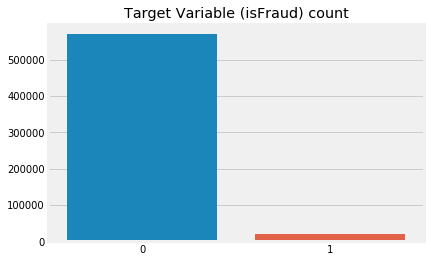

In [23]:
x = v_train['isFraud'].value_counts().values
sns.barplot([0,1],x)
plt.title('Target Variable (isFraud) count')
plt.show()

## Transaction Table
“It contains money transfer and also other gifting goods and service, like you booked a ticket for others, etc.”   

* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)  
* TransactionAMT: transaction payment amount in USD  
* ProductCD: product code, the product for each transaction  
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.  
* addr: address  
* dist: distance  
* P_ and (R__) emaildomain: purchaser and recipient email domain  
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.  
* D1-D15: timedelta, such as days between previous transaction, etc.  
* M1-M9: match, such as names on card and address, etc.  
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.  

**Categorical Features:**  
* ProductCD  
* card1 - card6  
* addr1, addr2  
* Pemaildomain Remaildomain  
* M1 - M9  

In [24]:
linking_cols = ['TransactionID', 'isFraud']

In [25]:
trans_categorical_features = ['ProductCD','card1', 'card2', 'card3', 'card4', 'card5', 'card6','addr1', 'addr2','P_emaildomain','R_emaildomain','M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
logger.info(f'Transaction Table Categorical Feature Set:\n{trans_categorical_features}')

Transaction Table Categorical Feature Set:
['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [26]:
# initial investigation of useful features
interesting_features = list(v_train.iloc[:, 3:55].columns)
logger.info(interesting_features)

['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


<Figure size 756x504 with 0 Axes>

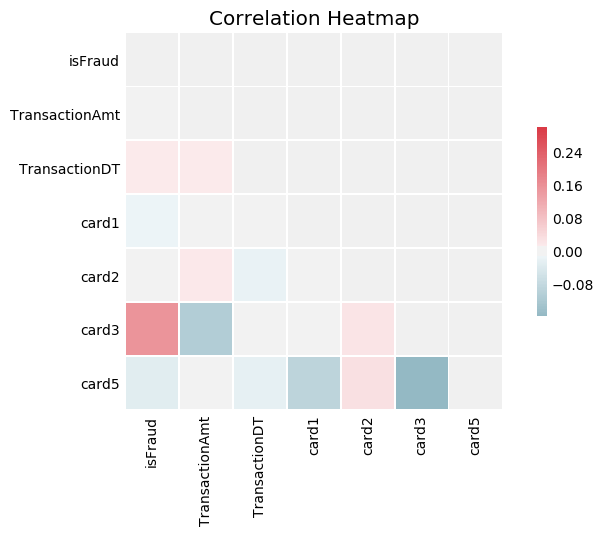

In [28]:
feature_list_1 = ['isFraud','TransactionAmt', 'TransactionDT','ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']
                 
feature_list_2 = ['isFraud','TransactionAmt','TransactionDT','addr1', 'addr2', 'dist1', 'dist2','P_emaildomain', 'R_emaildomain']

feature_list_3 = ['isFraud','TransactionAmt','C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

feature_list_4 = ['isFraud','TransactionAmt','D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']

feature_list_5 = ['isFraud','TransactionAmt','M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


df = v_train[feature_list_1]
plt.figure(figsize=(10.5,7))
auq.plot_corr_heatmap(df,df.columns)

### TransactionDT
“TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so I think the unit is seconds. Using this, we know the data spans 6 months, as the maximum value is 15811131, which would correspond to day 183.”   

In [29]:
transactionDTs = v_train[['TransactionDT','TransactionAmt']]
transactionDTs.head()

,TransactionDT,TransactionAmt
0,86400,68.5
1,86401,29.0
2,86469,59.0
3,86499,50.0
4,86506,50.0


### TransactionAMT
“Some of the transaction amounts have three decimal places to the right of the decimal point. There seems to be a link to three decimal places and a blank addr1 and addr2 field. Is it possible that these are foreign transactions and that, for example, the 75.887 in row 12 is the result of multiplying a foreign currency amount by an exchange rate?”   

In [30]:
# look at Transaction Amounts
logger.info(v_train['TransactionAmt'].isnull().sum().sum())
logger.info(v_train['TransactionAmt'].describe())

0
count    590540.000000
mean               NaN
std                NaN
min           0.250977
25%          43.312500
50%          68.750000
75%         125.000000
max       31936.000000
Name: TransactionAmt, dtype: float64


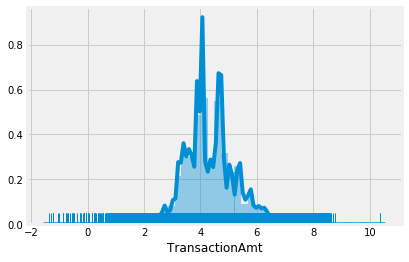

In [31]:
sns.distplot(np.log(v_train['TransactionAmt']), rug=True);

count    2.066300e+04
mean              inf
std               inf
min      2.919922e-01
25%      3.503125e+01
50%      7.500000e+01
75%      1.610000e+02
max      5.192000e+03
Name: TransactionAmt, dtype: float64


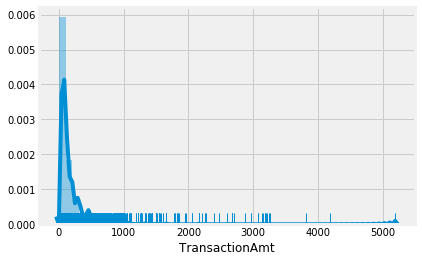

In [32]:
#sns.distplot(np.log(fraudDf['TransactionAmt']), rug=True)
logger.info(fraudDf['TransactionAmt'].describe())
sns.distplot(fraudDf['TransactionAmt'], rug=True);

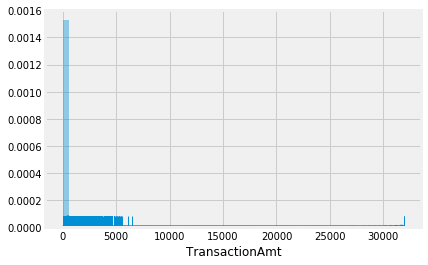

In [33]:
sns.distplot(notFraudDf['TransactionAmt'], rug=True);

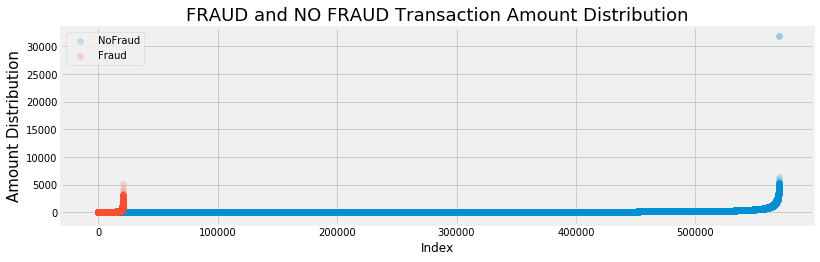

In [34]:
plt.figure(figsize=(12, 8))

plt.subplot(212)
g4 = plt.scatter(range(v_train[v_train['isFraud'] == 0].shape[0]), 
                np.sort(v_train[v_train['isFraud'] == 0]['TransactionAmt'].values), 
                label='NoFraud', alpha=.2)
g4 = plt.scatter(range(v_train[v_train['isFraud'] == 1].shape[0]), 
                np.sort(v_train[v_train['isFraud'] == 1]['TransactionAmt'].values), 
                label='Fraud', alpha=.2)
g4 = plt.title('FRAUD and NO FRAUD Transaction Amount Distribution', fontsize=18)
g4 = plt.xlabel('Index')
g4 = plt.ylabel('Amount Distribution', fontsize=15)
g4 = plt.legend()

plt.show()

### ProductCD
“Product isn't necessary to be a real 'product' (like one item to be added to the shopping cart). It could be any kind of service.”   

[W,H,C,S,R]

In [35]:
logger.info(f'Unique ProductCD Categories:\n{v_train["ProductCD"].unique()}')
print('')
logger.info(f'ProductCD frequency by TransactionID:\n {pd.DataFrame(v_train.groupby("ProductCD").count()["TransactionID"])}')

Unique ProductCD Categories:
[W, H, C, S, R]
Categories (5, object): [W, H, C, S, R]


ProductCD frequency by TransactionID:
            TransactionID
ProductCD               
C                  68519
H                  33024
R                  37699
S                  11628
W                 439670


### card1 - card6
payment card information, such as card type, card category, issue bank, country, etc.

Categorical:
* card4:
    * [discover, mastercard, visa, american express]   
* card6:
    * [credit, debit, debit or credit, charge card]   
    
Numeric:  **what do these numbers represent???**    
they appear to be some type of classifier with the shape 123.0 ...    

* card1:  
* card2:  
* card3:  
* card5:  

In [36]:
num_cardCols = ['card1','card2','card3','card5']
cat_cardCols = ['card4','card6']
card_cols = num_cardCols+cat_cardCols

In [37]:
for c in card_cols:
    logger.info(f'Unique {c} Categories:\n{v_train[c].unique()}')
    print('')
    logger.info(f'{c} frequency by TransactionID:\n {pd.DataFrame(v_train.groupby(c).count()["TransactionID"])}')

Unique card1 Categories:
[13926  2755  4663 ... 13166  8767 18038]


card1 frequency by TransactionID:
        TransactionID
card1               
1000               1
1001               3
1004               5
1005               1
1006               3
1007               2
1008               3
1009               5
1010               1
1011               2
1012               8
1013              11
1014               2
1015               8
1016              14
1018               3
1020               1
1021               7
1022               8
1023               3
1024               1
1026               1
1027              15
1028              37
1029               1
1030             123
1031               3
1032               1
1033               3
1034               5
1035               1
1036               8
1037               1
1038               1
1039             530
1040               1
1041               1
1042              10
1043               6
1045               1
1046               2
1047              22
1048               6
1049               5

Unique card2 Categories:
[ nan 404. 490. 567. 514. 555. 360. 100. 111. 352. 375. 418. 303. 314.
 543. 583. 148. 321. 269. 361. 272. 399. 569. 453. 417. 512. 545. 266.
 114. 481. 452. 547. 383. 170. 343. 556. 285. 562. 302. 264. 558. 500.
 396. 103. 206. 143. 243. 476. 199. 174. 423. 446. 492. 523. 440. 528.
 161. 535. 354. 117. 455. 325. 158. 268. 122. 479. 147. 215. 480. 265.
 388. 408. 309. 415. 414. 437. 104. 225. 101. 134. 586. 191. 491. 369.
 322. 494. 532. 313. 474. 324. 475. 298. 429. 432. 553. 566. 599. 296.
 251. 310. 242. 204. 250. 270. 346. 316. 194. 587. 390. 135. 536. 254.
 226. 327. 420. 260. 413. 428. 561. 387. 411. 392. 203. 297. 136. 276.
 142. 527. 210. 184. 459. 118. 585. 106. 588. 449. 176. 177. 246. 439.
 503. 445. 172. 468. 239. 496. 364. 533. 370. 578. 150. 458. 365. 359.
 509. 202. 584. 258. 442. 530. 489. 529. 504. 356. 123. 205. 130. 382.
 155. 105. 422. 345. 257. 171. 559. 271. 554. 127. 236. 548. 454. 373.
 275. 286. 308. 517. 294. 145. 565. 245. 513. 520. 1

card2 frequency by TransactionID:
        TransactionID
card2               
100.0           7570
101.0            156
102.0            332
103.0           3468
104.0            754
105.0            290
106.0            262
108.0             91
109.0             83
110.0            309
111.0          45191
112.0            269
113.0            347
114.0            101
115.0            195
116.0            109
117.0             62
118.0            185
119.0            231
120.0             66
121.0             73
122.0           2519
123.0            111
124.0             66
125.0             49
126.0            129
127.0           1350
128.0            105
129.0             83
130.0           2746
131.0            120
132.0             68
133.0            243
134.0            490
135.0             68
136.0             68
137.0             62
138.0            149
139.0             95
140.0             94
141.0            279
142.0           1685
143.0            657
144.0            210

Unique card3 Categories:
[150. 117. 185. 143. 144. 163. 146. 191. 162. 119. 147. 100. 135. 137.
 138. 102. 213. 106. 214. 148. 210. 203. 194. 141. 225.  nan 188. 193.
 208. 133. 223. 134. 153. 131. 200. 149. 116. 222. 220. 197. 129. 206.
 195. 204. 127. 142. 111. 159. 118. 229. 217. 212. 227. 166. 189. 120.
 171. 190. 105. 130. 170. 180. 177. 132. 109. 198. 121. 183. 215. 156.
 207. 186. 167. 152. 199. 219. 202. 126. 182. 123. 107. 221. 124. 231.
 157. 136. 128. 168. 101. 108. 125. 211. 164. 160. 161. 179. 155. 169.
 205. 209. 226. 174. 176. 181. 224. 122. 201. 175. 139. 172. 114. 228.
 184. 151. 173.]


card3 frequency by TransactionID:
        TransactionID
card3               
100.0            202
101.0              1
102.0            460
105.0              3
106.0           1571
107.0              6
108.0              5
109.0              8
111.0             39
114.0              1
116.0              8
117.0            962
118.0             17
119.0            750
120.0              6
121.0             99
122.0              4
123.0              3
124.0              3
125.0              1
126.0             23
127.0             28
128.0              7
129.0              9
130.0             10
131.0            172
132.0              1
133.0             50
134.0            166
135.0            120
136.0              3
137.0             71
138.0             70
139.0              1
141.0             49
142.0             40
143.0            899
144.0           1252
146.0           1252
147.0            390
148.0             61
149.0            127
150.0         521287
151.0              5

card5 frequency by TransactionID:
        TransactionID
card5               
100.0            978
101.0              7
102.0          29105
104.0             23
105.0              2
106.0              5
107.0             12
109.0              3
111.0             25
112.0              3
113.0              2
114.0              3
115.0              1
116.0              5
117.0          25941
118.0            752
119.0            219
120.0              1
121.0             12
122.0              5
123.0              2
125.0              1
126.0          10298
127.0             25
128.0              3
129.0            325
130.0             12
131.0            205
132.0            203
133.0            145
134.0             94
135.0            196
136.0             13
137.0          11720
138.0          19737
139.0             13
140.0              2
141.0            341
142.0            277
143.0             43
144.0            219
145.0              2
146.0            671
147.0            417

card4 frequency by TransactionID:
                   TransactionID
card4                          
american express           8328
discover                   6651
mastercard               189217
visa                     384767
Unique card6 Categories:
[credit, debit, NaN, debit or credit, charge card]
Categories (4, object): [credit, debit, debit or credit, charge card]


card6 frequency by TransactionID:
                  TransactionID
card6                         
charge card                 15
credit                  148986
debit                   439938
debit or credit             30


In [38]:
# cards
cols = ['TransactionID','isFraud'] + card_cols
cardsDf = v_train[cols]
cardsDf.head()

,TransactionID,isFraud,card1,card2,card3,card5,card4,card6
0,2987000,0,13926,NaN,150.0,142.0,discover,credit
1,2987001,0,2755,404.0,150.0,102.0,mastercard,credit
2,2987002,0,4663,490.0,150.0,166.0,visa,debit
3,2987003,0,18132,567.0,150.0,117.0,mastercard,debit
4,2987004,0,4497,514.0,150.0,102.0,mastercard,credit


### addr: address
**both addresses are for purchaser**  
* addr1 as billing region
* addr2 as billing country

In [39]:
logger.info(f'Unique addr1 Categories:\n{v_train["addr1"].unique()}')
print('')
logger.info(f'addr1 (biling region) frequency by TransactionID:\n{pd.DataFrame(v_train.groupby("addr1").count()["TransactionID"])}')

Unique addr1 Categories:
[315. 325. 330. 476. 420. 272. 126. 337. 204.  nan 226. 170. 184. 264.
 299. 441. 472. 251. 469. 191. 485. 122. 220. 205. 387. 181. 231. 436.
 327. 343. 123. 502. 269. 158. 433. 143. 225. 492. 177. 512. 310. 308.
 418. 494. 253. 428. 203. 110. 444. 498. 194. 536. 384. 324. 295. 448.
 157. 171. 224. 491. 274. 432. 459. 106. 296. 254. 452. 347. 335. 305.
 161. 221. 154. 130. 465. 451. 331. 511. 486. 312. 242. 131. 508. 332.
 283. 216. 431. 391. 333. 496. 304. 167. 261. 399. 164. 142. 393. 258.
 375. 483. 404. 482. 148. 218. 127. 403. 374. 477. 478. 241. 504. 453.
 535. 100. 239. 152. 500. 356. 198. 162. 244. 520. 531. 401. 427. 352.
 540. 456. 371. 409. 529. 505. 503. 346. 359. 499. 298. 190. 454. 172.
 145. 493. 119. 521. 270. 395. 366. 348. 313. 338. 139. 443. 183. 430.
 102. 470. 133. 233. 468. 185. 523. 411. 501. 425. 426. 365. 129. 141.
 137. 249. 402. 386. 290. 111. 132. 278. 506. 128. 213. 514. 314. 445.
 252. 328. 210. 144. 193. 382. 306. 385. 235. 339. 2

addr1 (biling region) frequency by TransactionID:
       TransactionID
addr1               
100.0             26
101.0              1
102.0             13
104.0              8
105.0              3
106.0             20
110.0           3220
111.0              2
112.0              2
113.0              1
117.0              1
119.0              3
120.0              1
122.0           1617
123.0          16105
124.0              1
125.0              4
126.0          15243
127.0              1
128.0              1
129.0              1
130.0            342
131.0              1
132.0              1
133.0              1
134.0             11
137.0              1
139.0              1
141.0              2
142.0             16
143.0           9806
144.0              3
145.0              3
146.0              2
148.0             96
151.0              1
152.0              7
153.0              1
154.0             13
155.0             18
156.0              1
157.0            169
158.0           1562
159.0

In [40]:
logger.info(f'Unique addr2 Categories:\n{v_train["addr2"].unique()}')
print('')
logger.info(f'addr2 (biling country) frequency by TransactionID:\n{pd.DataFrame(v_train.groupby("addr2").count()["TransactionID"])}')

Unique addr2 Categories:
[ 87.  nan  96.  35.  60.  98.  43.  65.  32.  13.  31. 101.  24.  16.
  15.  19.  71.  59. 102.  44.  26.  69.  47.  78.  88.  66.  72.  22.
  57.  25.  17.  30.  29.  21.  14.  49.  83.  75.  34.  86.  48.  68.
  23.  70.  62.  54.  50.  52.  39.  76.  10.  73.  97.  63.  27.  28.
  38.  74.  77.  92.  79.  84.  82.  40.  36.  46.  18.  20.  89.  61.
  94. 100.  55.  51.  93.]


addr2 (biling country) frequency by TransactionID:
       TransactionID
addr2               
10.0               8
13.0               7
14.0               1
15.0               1
16.0              55
17.0               7
18.0               3
19.0              33
20.0               3
21.0               5
22.0               1
23.0               2
24.0               3
25.0               1
26.0              25
27.0              20
28.0               4
29.0              11
30.0               4
31.0              47
32.0              91
34.0              16
35.0               1
36.0               2
38.0               3
39.0               3
40.0               3
43.0              12
44.0               3
46.0               3
47.0               4
48.0               4
49.0               1
50.0               1
51.0               4
52.0               5
54.0               6
55.0               1
57.0              10
59.0              17
60.0            3084
61.0               3
62.0               4
63.0

In [41]:
addr_cols = ['addr1','addr2']
addrDf = v_train[linking_cols+addr_cols]
addrDf.head()

,TransactionID,isFraud,addr1,addr2
0,2987000,0,315.0,87.0
1,2987001,0,325.0,87.0
2,2987002,0,330.0,87.0
3,2987003,0,476.0,87.0
4,2987004,0,420.0,87.0


### dist: distance
distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.  

In [42]:
dist_cols = ['dist1','dist2']
distDf = v_train[linking_cols+dist_cols]
distDf.head()

,TransactionID,isFraud,dist1,dist2
0,2987000,0,19.0,NaN
1,2987001,0,NaN,NaN
2,2987002,0,287.0,NaN
3,2987003,0,NaN,NaN
4,2987004,0,NaN,NaN


In [43]:
print_descriptive_metrics(distDf,'dist1')
print_descriptive_metrics(distDf,'dist2')

dist1 median: [8.0] | mean: [118.5] | std: [inf] | min: [0.0] | max: [10288.0]
dist2 median: [37.0] | mean: [231.875] | std: [inf] | min: [0.0] | max: [11624.0]


(37.0, 231.9, inf, 0.0, 11624.0)

Distance Correlation
               TransactionID   isFraud     dist1     dist2
TransactionID       1.000000  0.014166 -0.027044 -0.026272
isFraud             0.014166  1.000000  0.021523 -0.019054
dist1              -0.027044  0.021523  1.000000       NaN
dist2              -0.026272 -0.019054       NaN  1.000000


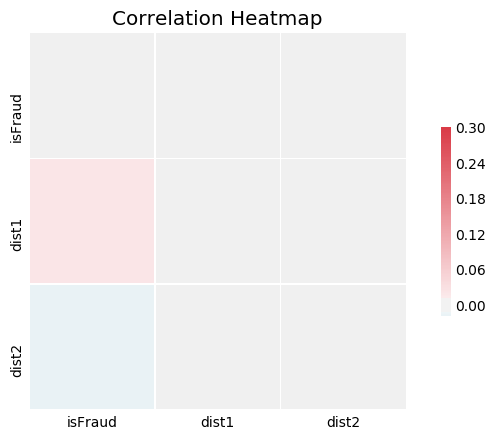

In [44]:
logger.info(f'Distance Correlation\n{distDf.corr()}')
auq.plot_corr_heatmap(distDf,distDf.drop(columns='TransactionID').columns)

Address & Distance Correlation with is Fraud
               TransactionID   isFraud     addr1     addr2     dist1     dist2
TransactionID       1.000000  0.014166 -0.000370  0.057213 -0.027044 -0.026272
isFraud             0.014166  1.000000  0.005596 -0.030387  0.021523 -0.019054
addr1              -0.000370  0.005596  1.000000 -0.002765 -0.001210  0.004686
addr2               0.057213 -0.030387 -0.002765  1.000000 -0.038691  0.010228
dist1              -0.027044  0.021523 -0.001210 -0.038691  1.000000       NaN
dist2              -0.026272 -0.019054  0.004686  0.010228       NaN  1.000000


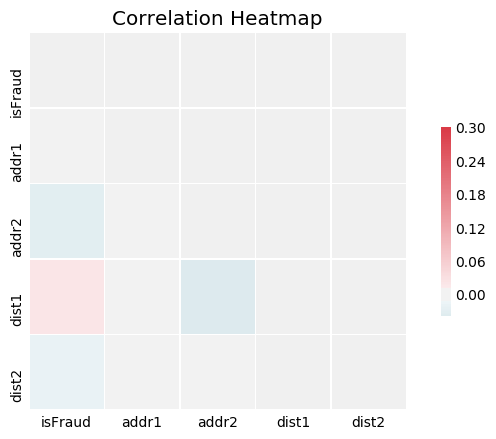

In [45]:
# addr and dist fit well together
addr_dist_df = v_train[linking_cols+addr_cols+dist_cols]
addr_dist_df.head()
logger.info(f'Address & Distance Correlation with is Fraud\n{addr_dist_df.corr()}')
auq.plot_corr_heatmap(addr_dist_df,addr_dist_df.drop(columns='TransactionID').columns)

### P_ and (R_) emaildomain
purchaser and recipient email domain “ certain transactions don't need recipient, so Remaildomain is null   

In [46]:
v_train[['P_emaildomain','R_emaildomain']][:20]

,P_emaildomain,R_emaildomain
0,NaN,NaN
1,gmail.com,NaN
2,outlook.com,NaN
3,yahoo.com,NaN
4,gmail.com,NaN
5,gmail.com,NaN
6,yahoo.com,NaN
7,mail.com,NaN
8,anonymous.com,NaN
9,yahoo.com,NaN


In [47]:
logger.info(f'Unique P_emaildomain Categories:\n{v_train["P_emaildomain"].unique()}')
logger.info(f'Unique R_emaildomain Categories:\n{v_train["R_emaildomain"].unique()}')

Unique P_emaildomain Categories:
[NaN, gmail.com, outlook.com, yahoo.com, mail.com, ..., hotmail.fr, hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]
Length: 60
Categories (59, object): [gmail.com, outlook.com, yahoo.com, mail.com, ..., hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]
Unique R_emaildomain Categories:
[NaN, gmail.com, hotmail.com, outlook.com, anonymous.com, ..., rocketmail.com, centurylink.net, protonmail.com, cableone.net, sc.rr.com]
Length: 61
Categories (60, object): [gmail.com, hotmail.com, outlook.com, anonymous.com, ..., centurylink.net, protonmail.com, cableone.net, sc.rr.com]


In [48]:
pd.DataFrame(v_train.groupby("P_emaildomain").count().TransactionID)

,TransactionID
P_emaildomain,
aim.com,315
anonymous.com,36998
aol.com,28289
att.net,4033
bellsouth.net,1909
cableone.net,159
centurylink.net,205
cfl.rr.com,172
charter.net,816


### C1-C14
counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.  
* like counts of phone numbers, email addresses, names associated with the user  
* like device, ipaddr, billingaddr, etc  
* these are for both purchaser and recipient, which doubles the number.  

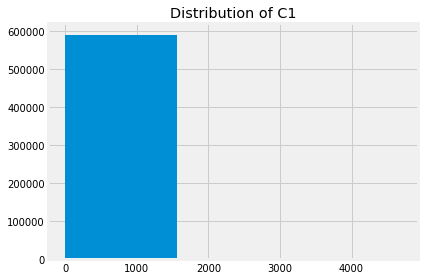

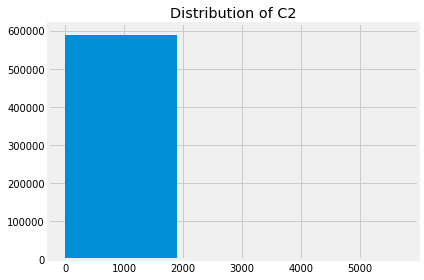

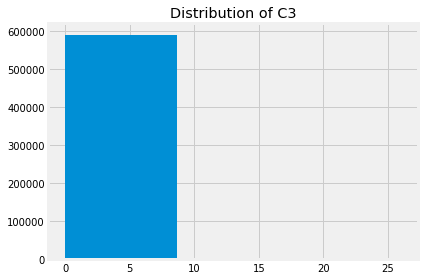

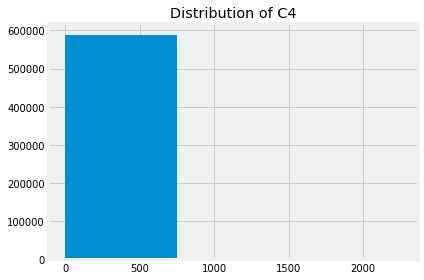

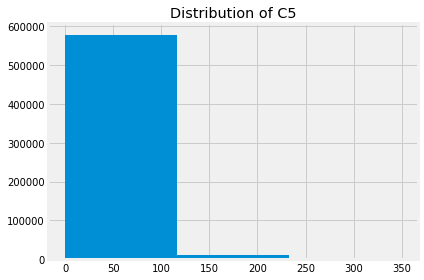

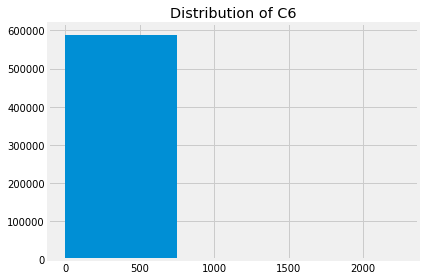

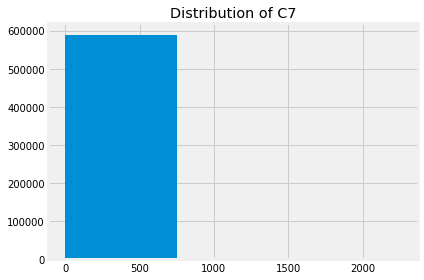

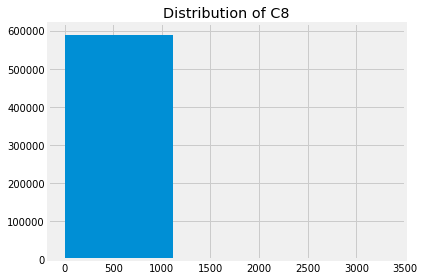

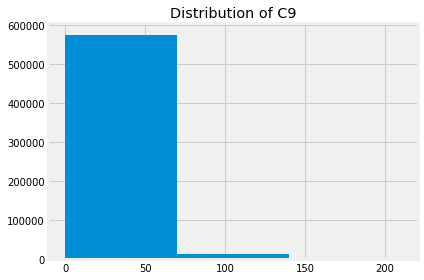

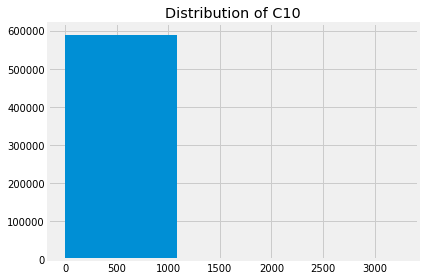

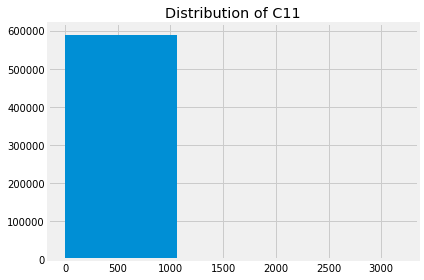

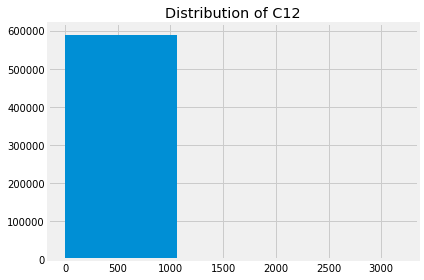

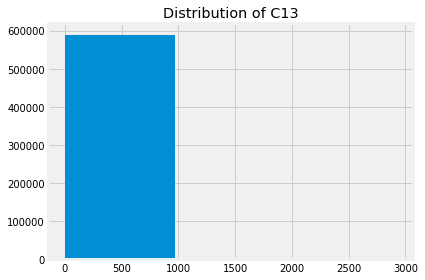

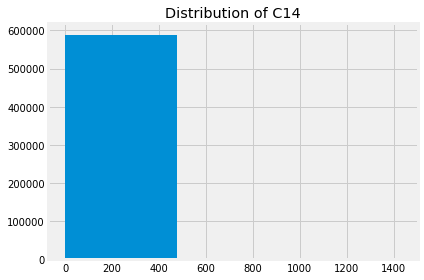

In [49]:
num_c = ['C'+str(i) for i in range(1,15)]
for i in num_c:
    plt.hist(v_train[f'{i}'], bins=3)
    plt.title(f'Distribution of {i}')
    plt.tight_layout()
    plt.show()

### D1-D15
timedelta, such as days between previous transaction  

### M1-M9
match, such as names on card and address, etc

* M1:  
    * [T, F]   
* M2:
    * [T, F]  
* M3:
    * [T, F]  
* M4:
    * [M2, M0, M1]  
* M5:
    * [F, T]  
* M6:  
    * [T, F]  
* M7:
    * [F, T]  
* M8:  
    * [F, T]  
* M9:
    * [F, T]  

### Vxxx: 
Vesta engineered rich features, including ranking, counting, and other entity relations.  
For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc   

Total Count of these features: **339**...

In [50]:
# what value do these bring if they are engineered by Vesta and there's no way to access there data definitions for validation
# they should be removed from the training set
# consider narrowing these features through PCA
import re
vCols = []
for col in v_train.columns:
    z = re.findall(r'(^V\w+)',col)
    if len(z) > 0:
        vCols.append(z[0])
    #print(z)
    
logger.debug(vCols)
logger.info(f'Vesta Engenered Attributes Count: [{len(vCols)}] | Total Attribute Count: [{len(v_train.columns)}]')

Vesta Engenered Attributes Count: [339] | Total Attribute Count: [434]


In [51]:
vKeep = ['TransactionID','isFraud']+vCols
vesta_rich = v_train[vKeep]
vesta_rich.head()

,TransactionID,isFraud,V1,V2,V3,V4,V5,V6,V7,V8,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Identity Table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)  

**Categorical Features:**    
* DeviceType  
* DeviceInfo  
* id12 - id38  

In [52]:
cat_ids_1 = ['id_1'+str(i) for i in range(2,10)]
cat_ids_2 = ['id_2'+str(i) for i in range(0,10)]
cat_ids_3 = ['id_3'+str(i) for i in range(0,9)]
cat_ids = cat_ids_1 + cat_ids_2 + cat_ids_3
#cat_ids
ident_categorical_features = ['DeviceType', 'DeviceInfo']+cat_ids
logger.info(f'Identity Table Categorical Feature Set:\n{ident_categorical_features}')

categorical_features = trans_categorical_features+ident_categorical_features

Identity Table Categorical Feature Set:
['DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


### DeviceType
**categorical**  
(desktop, mobile)

In [53]:
v_train['DeviceType']

0             NaN
1             NaN
2             NaN
3             NaN
4          mobile
5             NaN
6             NaN
7             NaN
8          mobile
9             NaN
10        desktop
11        desktop
12            NaN
13            NaN
14            NaN
15            NaN
16        desktop
17        desktop
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
30            NaN
31            NaN
32            NaN
33            NaN
34            NaN
35            NaN
36            NaN
37            NaN
38         mobile
39            NaN
40        desktop
41            NaN
42            NaN
43            NaN
44            NaN
45            NaN
46            NaN
47            NaN
48        desktop
49        desktop
50            NaN
51            NaN
52            NaN
53            NaN
54            NaN
55        

### DeviceInfo
**category**
1787 Unique Values   

In [54]:
logger.info(f'Identity Table, DeviceInfo Unique Values:\n{v_train["DeviceInfo"].unique()}')

Identity Table, DeviceInfo Unique Values:
[NaN, SAMSUNG SM-G892A Build/NRD90M, iOS Device, Windows, MacOS, ..., G630-U251, LG-K212, LDN-LX3 Build/HUAWEILDN-LX3, Z955A, LG-E975]
Length: 1787
Categories (1786, object): [SAMSUNG SM-G892A Build/NRD90M, iOS Device, Windows, MacOS, ..., LG-K212, LDN-LX3 Build/HUAWEILDN-LX3, Z955A, LG-E975]


### id fields
id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. 

* **id01-id11 - numerical**  
* **id12-id38 - categorical**  

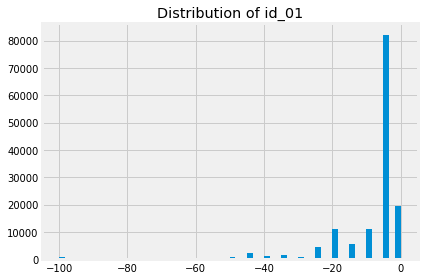

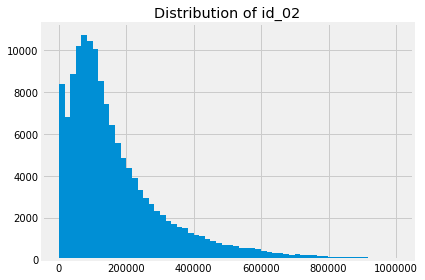

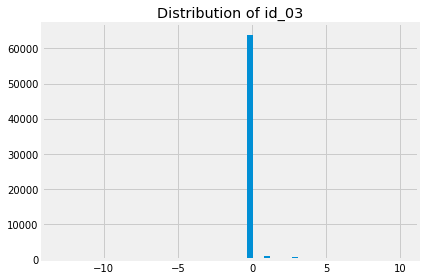

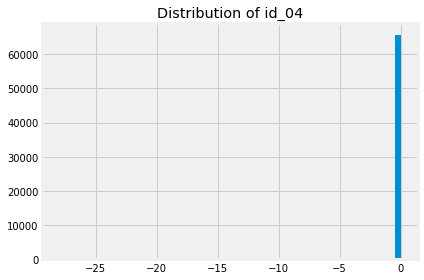

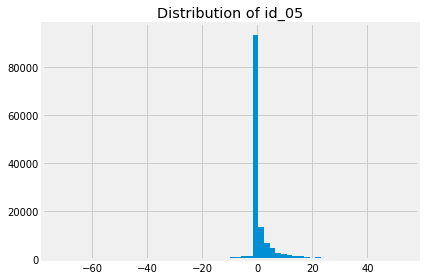

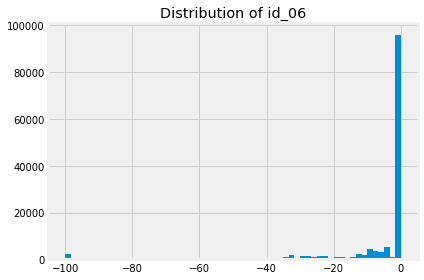

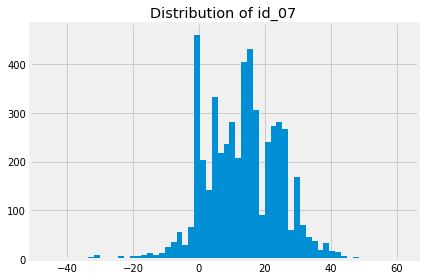

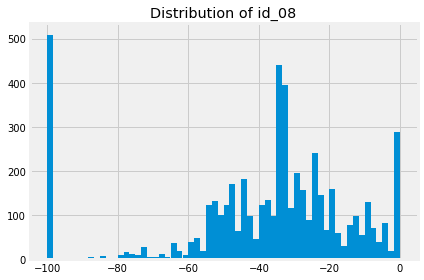

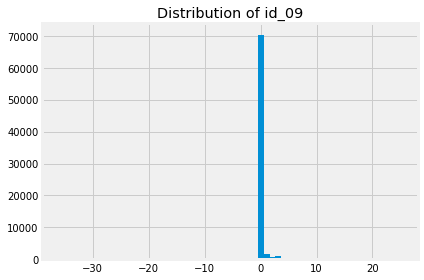

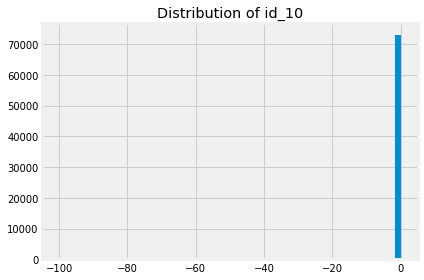

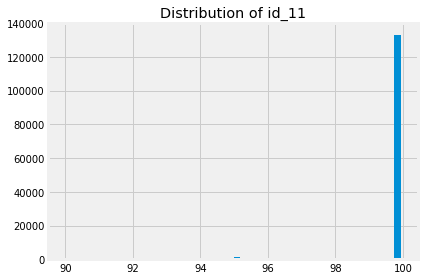

In [55]:
num_ids = ['id_0'+str(i) for i in range(1,10)]
num_ids = num_ids + ['id_10','id_11']
for i in num_ids:
    plt.hist(v_train[f'{i}'], bins=60)
    plt.title(f'Distribution of {i}')
    plt.tight_layout()
    plt.show()

### Make reusable datasets
Save copies of the various datasets to be used by other applications.... 

#### Experiment - First reduction in dataset and basic cleaning

In [56]:
# making simplified dataframe, narrowing attributes - experimentation...
#linking_cols
#interesting_features
#num_ids # convert NaN to zero

#TEST - TAKING num_ids out - see how nn responds

core_fraud_train_df = v_train[linking_cols+interesting_features]#+num_ids] # removed num_ids
core_fraud_test_df = v_test[['TransactionID']+interesting_features]#+num_ids] # removed num_ids
logger.info(core_fraud_train_df.head())

continuous_features = list(filter(lambda x: x not in categorical_features, core_fraud_train_df))
continuous_features.remove('TransactionID')
continuous_features.remove('isFraud')
logger.info(continuous_features)

   TransactionID  isFraud  TransactionAmt ProductCD  card1  card2  card3  \
0        2987000        0            68.5         W  13926    NaN  150.0   
1        2987001        0            29.0         W   2755  404.0  150.0   
2        2987002        0            59.0         W   4663  490.0  150.0   
3        2987003        0            50.0         W  18132  567.0  150.0   
4        2987004        0            50.0         H   4497  514.0  150.0   

        card4  card5   card6  ...    D15   M1   M2   M3   M4   M5   M6   M7  \
0    discover  142.0  credit  ...    0.0    T    T    T   M2    F    T  NaN   
1  mastercard  102.0  credit  ...    0.0  NaN  NaN  NaN   M0    T    T  NaN   
2        visa  166.0   debit  ...  315.0    T    T    T   M0    F    F    F   
3  mastercard  117.0   debit  ...  111.0  NaN  NaN  NaN   M0    T    F  NaN   
4  mastercard  102.0  credit  ...    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

    M8   M9  
0  NaN  NaN  
1  NaN  NaN  
2    F    F  
3  NaN  NaN 

In [57]:
core_fraud_train_df.columns

Index(['TransactionID', 'isFraud', 'TransactionAmt', 'ProductCD', 'card1',
       'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
       'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5',
       'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2',
       'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13',
       'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [58]:
core_fraud_test_df.columns

Index(['TransactionID', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2',
       'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3',
       'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
       'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [60]:
# for the identity id fields, fill na with 0.0
#for i in num_ids:
    #core_fraud_train_df[i].fillna(0.0,inplace=True)
    #core_fraud_test_df[i].fillna(0.0,inplace=True)

### C - Clean and Transform

In [61]:
# fill na with median value
def transform_c(df, cols):
    
    for c in cols:
        logger.info(c)
        if df[c].isna().sum() > 0:
            stats = print_descriptive_metrics(df,c)
            logger.info(stats[0])
            df[c].fillna(stats[0],inplace=True)
    
    return df

In [62]:
core_fraud_test_df['C2'].isna().sum()
#np.median(core_fraud_train_df['C1'].sort_values().dropna())

3

In [63]:
# for c fill na with 0.0
c_cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']

# train
core_fraud_train_df = transform_c(core_fraud_train_df, c_cols)
logger.info(f'training data set {c}:\n{core_fraud_train_df[c].describe()}')
print('')
logger.info(auq.getColumnsNaNCnts(core_fraud_train_df[c_cols],logger))

# test
core_fraud_test_df = transform_c(core_fraud_test_df, c_cols)
logger.info(f'testing data set {c}:\n{core_fraud_test_df[c_cols].describe()}')
print('')
logger.info(auq.getColumnsNaNCnts(core_fraud_test_df[c_cols],logger))

C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
training data set card6:
count     588969
unique         4
top        debit
freq      439938
Name: card6, dtype: object


0
C1
C1 median: [1.0] | mean: [10.09375] | std: [inf] | min: [0.0] | max: [2950.0]
1.0
C2
C2 median: [1.0] | mean: [10.7109375] | std: [inf] | min: [0.0] | max: [3276.0]
1.0
C3
C3 median: [0.0] | mean: [0.02740478515625] | std: [0.227783203125] | min: [0.0] | max: [31.0]
0.0
C4
C4 median: [0.0] | mean: [2.38671875] | std: [inf] | min: [0.0] | max: [1601.0]
0.0
C5
C5 median: [0.0] | mean: [4.9609375] | std: [inf] | min: [0.0] | max: [376.0]
0.0
C6
C6 median: [1.0] | mean: [6.85546875] | std: [inf] | min: [0.0] | max: [1601.0]
1.0
C7
C7 median: [0.0] | mean: [1.677734375] | std: [inf] | min: [0.0] | max: [1621.0]
0.0
C8
C8 median: [0.0] | mean: [1.8935546875] | std: [inf] | min: [0.0] | max: [1005.0]
0.0
C9
C9 median: [1.0] | mean: [4.61328125] | std: [inf] | min: [0.0] | max: [572.0]
1.0
C10
C10 median: [0.0] | mean: [1.810546875] | std: [inf] | min: [0.0] | max: [881.0]
0.0
C11
C11 median: [1.0] | mean: [7.484375] | std: [inf] | min: [0.0] | max: [2234.0]
1.0
C12
C12 median: [0.0] | me

0


### D - Clean and Transform

In [64]:
# for d fill na with 0.0
d_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
logger.info(auq.getColumnsNaNCnts(core_fraud_train_df[d_cols],logger))
logger.info(core_fraud_train_df['D1'].describe())

# replace with 0.0
for i in d_cols:
    core_fraud_train_df[i].fillna(0.0,inplace=True)
    core_fraud_test_df[i].fillna(0.0,inplace=True)

logger.info(auq.getColumnsNaNCnts(core_fraud_train_df[d_cols],logger))
logger.info(core_fraud_train_df['D1'].describe())

[('D1', 1269), ('D2', 280797), ('D3', 262878), ('D4', 168922), ('D5', 309841), ('D6', 517353), ('D7', 551623), ('D8', 515614), ('D9', 515614), ('D10', 76022), ('D11', 279287), ('D12', 525823), ('D13', 528588), ('D14', 528353), ('D15', 89113)]
count    589271.0
mean          NaN
std           NaN
min           0.0
25%           0.0
50%           3.0
75%         122.0
max         640.0
Name: D1, dtype: float64
0
count    590540.0
mean          NaN
std           NaN
min           0.0
25%           0.0
50%           3.0
75%         121.0
max         640.0
Name: D1, dtype: float64


### M - Clean and Transform

In [65]:
def transform_m(df, att, type='b'):
    replace_na = 'U'
    df[att] = df[att].astype('str')
    if not type == 'b':
        replace_na = 'UK'
    categories = list(df[att].unique())
    
    try:
        categories = list(np.delete(categories, categories.index('nan')))
    except:
        pass
    # replace nan with unknown
    df[att] = df[att].apply(lambda x: x if x in categories else replace_na)
    df[att] = pd.Categorical(df[att], ordered=False, categories=list(df[att].unique()))
    
    logger.info(f'{att} unique categories: {df[att].unique()}')
    return df

In [66]:
m_cols = ['M1', 'M2', 'M3','M5', 'M6', 'M7', 'M8', 'M9'] # 
# train
for m in m_cols:
    core_fraud_train_df = transform_m(core_fraud_train_df,m,type='b')
    core_fraud_test_df = transform_m(core_fraud_test_df,m,type='b')

# M4
core_fraud_train_df = transform_m(core_fraud_train_df,'M4',type='n')
core_fraud_test_df = transform_m(core_fraud_test_df,'M4',type='n')

M1 unique categories: [T, U, F]
Categories (3, object): [T, U, F]
M1 unique categories: [T, U, F]
Categories (3, object): [T, U, F]
M2 unique categories: [T, U, F]
Categories (3, object): [T, U, F]
M2 unique categories: [T, F, U]
Categories (3, object): [T, F, U]
M3 unique categories: [T, U, F]
Categories (3, object): [T, U, F]
M3 unique categories: [F, T, U]
Categories (3, object): [F, T, U]
M5 unique categories: [F, T, U]
Categories (3, object): [F, T, U]
M5 unique categories: [U, F, T]
Categories (3, object): [U, F, T]
M6 unique categories: [T, F, U]
Categories (3, object): [T, F, U]
M6 unique categories: [F, T, U]
Categories (3, object): [F, T, U]
M7 unique categories: [U, F, T]
Categories (3, object): [U, F, T]
M7 unique categories: [T, U, F]
Categories (3, object): [T, U, F]
M8 unique categories: [U, F, T]
Categories (3, object): [U, F, T]
M8 unique categories: [T, U, F]
Categories (3, object): [T, U, F]
M9 unique categories: [U, F, T]
Categories (3, object): [U, F, T]
M9 unique 

### Card - Clean and Transform

In [67]:
def transform_card(df, att, type='cat'):
    replace_na = 'unknown'
    df[att] = df[att].astype('str')
    if not type == 'cat':
        df[att] = [a.replace('.0','') for a in df[att]]
        replace_na = '-999'
    categories = list(df[att].unique())
    
    try:
        categories = list(np.delete(categories, categories.index('nan')))
    except:
        pass
    # replace nan with unknown
    df[att] = df[att].apply(lambda x: x if x in categories else replace_na)
    df[att] = pd.Categorical(df[att], ordered=False, categories=list(df[att].unique()))
    
    logger.info(f'{att} unique categories: {df[att].unique()}')
    return df

In [68]:
pd.DataFrame(core_fraud_train_df.groupby("card1").count()["TransactionID"])

,TransactionID
card1,
1000,1
1001,3
1004,5
1005,1
1006,3
1007,2
1008,3
1009,5
1010,1


In [69]:
num_cardCols = ['card1','card2','card3','card5']
cat_cardCols = ['card4','card6']
#card_cols = num_cardCols+cat_cardCols

# train / test
for c in num_cardCols:
    core_fraud_train_df = transform_card(core_fraud_train_df,c,type='num')
    core_fraud_test_df = transform_card(core_fraud_test_df,c,type='num')

for c in cat_cardCols:
    core_fraud_train_df = transform_card(core_fraud_train_df,c)
    core_fraud_test_df = transform_card(core_fraud_test_df,c)


card1 unique categories: [13926, 2755, 4663, 18132, 4497, ..., 7236, 17972, 13166, 8767, 18038]
Length: 13553
Categories (13553, object): [13926, 2755, 4663, 18132, ..., 17972, 13166, 8767, 18038]
card1 unique categories: [10409, 4272, 4476, 10989, 18018, ..., 16248, 3755, 4126, 1350, 3644]
Length: 13244
Categories (13244, object): [10409, 4272, 4476, 10989, ..., 3755, 4126, 1350, 3644]
card2 unique categories: [-999, 404, 490, 567, 514, ..., 526, 187, 223, 557, 312]
Length: 501
Categories (501, object): [-999, 404, 490, 567, ..., 187, 223, 557, 312]
card2 unique categories: [111, 574, 360, 452, 321, ..., 576, 213, 329, 531, 107]
Length: 498
Categories (498, object): [111, 574, 360, 452, ..., 213, 329, 531, 107]
card3 unique categories: [150, 117, 185, 143, 144, ..., 114, 228, 184, 151, 173]
Length: 115
Categories (115, object): [150, 117, 185, 143, ..., 228, 184, 151, 173]
card3 unique categories: [150, 185, 146, 188, 106, ..., 192, 181, 186, 154, 104]
Length: 116
Categories (116, obj

In [70]:
core_fraud_train_df['card2'].unique()

[-999, 404, 490, 567, 514, ..., 526, 187, 223, 557, 312]
Length: 501
Categories (501, object): [-999, 404, 490, 567, ..., 187, 223, 557, 312]

### Addr - Clean and Transform

In [71]:
def transform_addr(df,addr_att):
    df[addr_att] = df[addr_att].astype('str')
    df[addr_att] = [a.replace('.0','') for a in df[addr_att]]
    
    #df[addr_att] = df[addr_att].replace('.0','')
    a_categories = list(df[addr_att].unique())
    
    try:
        a_categories = list(np.delete(a_categories, a_categories.index('nan')))
    except:
        pass
    # replace nan with unknown
    df[addr_att] = df[addr_att].apply(lambda x: x if x in a_categories else '-999')
    df[addr_att] = pd.Categorical(df[addr_att], ordered=False, categories=list(df[addr_att].unique()))
    
    logger.info(f'{addr_att} unique categories: {df[addr_att].unique()}')
    return df

In [72]:
# train
core_fraud_train_df = transform_addr(core_fraud_train_df,'addr1')
core_fraud_train_df = transform_addr(core_fraud_train_df,'addr2')

# test
core_fraud_test_df = transform_addr(core_fraud_test_df,'addr1')
core_fraud_test_df = transform_addr(core_fraud_test_df,'addr2')

addr1 unique categories: [315, 325, 330, 476, 420, ..., 286, 507, 457, 268, 245]
Length: 333
Categories (333, object): [315, 325, 330, 476, ..., 507, 457, 268, 245]
addr2 unique categories: [87, -999, 96, 35, 60, ..., 94, 100, 55, 51, 93]
Length: 75
Categories (75, object): [87, -999, 96, 35, ..., 100, 55, 51, 93]
addr1 unique categories: [170, 299, 472, 205, 264, ..., 138, 482, 141, 152, 267]
Length: 293
Categories (293, object): [170, 299, 472, 205, ..., 482, 141, 152, 267]
addr2 unique categories: [87, -999, 12, 96, 57, ..., 58, 11, 10, 18, 46]
Length: 73
Categories (73, object): [87, -999, 12, 96, ..., 11, 10, 18, 46]


In [ ]:
#logger.info(f'Unique addr1 Categories:\n{core_fraud_train_df["addr1"].unique()}')
#print('')
#logger.info(f'addr1 (biling region) frequency by TransactionID:\n{pd.DataFrame(core_fraud_train_df.groupby("addr1").count()["TransactionID"])}')

In [ ]:
#logger.info(f'Unique addr2 Categories:\n{core_fraud_train_df["addr2"].unique()}')
#print('')
#logger.info(f'addr2 (biling country) frequency by TransactionID:\n{pd.DataFrame(core_fraud_train_df.groupby("addr2").count()["TransactionID"])}')

### email - Clean and Transform

In [73]:
def transform_emails(df,email_att):
    df[email_att] = df[email_att].astype('str')
    e_categories = list(df[email_att].unique())
    
    try:
        e_categories = list(np.delete(e_categories, e_categories.index('nan')))
    except:
        pass
    # replace nan with unknown
    df[email_att] = df[email_att].apply(lambda x: x if x in e_categories else 'unknown')
    df[email_att] = pd.Categorical(df[email_att], ordered=False, categories=list(df[email_att].unique()))
    
    logger.info(f'{email_att} unique categories: {df[email_att].unique()}')
    return df

In [74]:
# train
core_fraud_train_df = transform_emails(core_fraud_train_df,'P_emaildomain')
core_fraud_train_df = transform_emails(core_fraud_train_df,'R_emaildomain')

# test
core_fraud_test_df = transform_emails(core_fraud_test_df,'P_emaildomain')
core_fraud_test_df = transform_emails(core_fraud_test_df,'R_emaildomain')


P_emaildomain unique categories: [unknown, gmail.com, outlook.com, yahoo.com, mail.com, ..., hotmail.fr, hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]
Length: 60
Categories (60, object): [unknown, gmail.com, outlook.com, yahoo.com, ..., hotmail.de, hotmail.co.uk, protonmail.com, yahoo.co.jp]
R_emaildomain unique categories: [unknown, gmail.com, hotmail.com, outlook.com, anonymous.com, ..., rocketmail.com, centurylink.net, protonmail.com, cableone.net, sc.rr.com]
Length: 61
Categories (61, object): [unknown, gmail.com, hotmail.com, outlook.com, ..., centurylink.net, protonmail.com, cableone.net, sc.rr.com]
P_emaildomain unique categories: [gmail.com, aol.com, hotmail.com, unknown, att.net, ..., yahoo.co.jp, hotmail.fr, gmx.de, servicios-ta.com, scranton.edu]
Length: 61
Categories (61, object): [gmail.com, aol.com, hotmail.com, unknown, ..., hotmail.fr, gmx.de, servicios-ta.com, scranton.edu]
R_emaildomain unique categories: [unknown, hotmail.com, gmail.com, anonymous.com, att.

### dist - Clean and Transform

In [75]:
# handle dist1, dist2 - continuous - fill with median value
d1_stats_train = print_descriptive_metrics(core_fraud_train_df,'dist1')
d1_stats_test = print_descriptive_metrics(core_fraud_test_df,'dist1')

d2_stats_train = print_descriptive_metrics(core_fraud_train_df,'dist2')
d2_stats_test = print_descriptive_metrics(core_fraud_test_df,'dist2')

#dist1
core_fraud_train_df['dist1'].fillna(d1_stats_train[0],inplace=True)
core_fraud_test_df['dist1'].fillna(d1_stats_test[0],inplace=True)

#dist2
core_fraud_train_df['dist2'].fillna(d2_stats_train[0],inplace=True)
core_fraud_test_df['dist2'].fillna(d2_stats_test[0],inplace=True)

dist1 median: [8.0] | mean: [118.5] | std: [inf] | min: [0.0] | max: [10288.0]
dist1 median: [8.0] | mean: [87.0625] | std: [inf] | min: [0.0] | max: [8080.0]
dist2 median: [37.0] | mean: [231.875] | std: [inf] | min: [0.0] | max: [11624.0]
dist2 median: [44.0] | mean: [237.125] | std: [inf] | min: [0.0] | max: [9216.0]


In [76]:
logger.info(auq.getColumnsNaNCnts(core_fraud_train_df,logger))
logger.info(auq.getColumnsNaNCnts(core_fraud_test_df,logger))

0
0


In [ ]:
# save dataframes for use by other apps

## SAVE TRANSFORMED DATA SET

In [77]:
#core_fraud_train_df
#core_fraud_test_df

auq.save_df(core_fraud_train_df, f'{dataDir}core_fraud_train.pkl', logger)
auq.save_df(core_fraud_test_df, f'{dataDir}core_fraud_test.pkl', logger)

In [ ]:
#continuous_train = core_fraud_train_df[continuous_features]
#continuous_test = core_fraud_test_df[continuous_features]

#continuous_train['isna_sum'] = continuous_train.isna().sum(axis=1)
#continuous_test['isna_sum'] = continuous_test.isna().sum(axis=1)

#continuous_train['isna_sum'] = (continuous_train['isna_sum'] - continuous_train['isna_sum'].mean())/continuous_train['isna_sum'].std()
#continuous_test['isna_sum'] = (continuous_test['isna_sum'] - continuous_test['isna_sum'].mean())/continuous_test['isna_sum'].std()

#logger.info(continuous_train['isna_sum'])
#logger.info(continuous_test['isna_sum'])

## -----------------------------------------------------------------------------
## Local Utility Functions - Run these sections second
## -----------------------------------------------------------------------------

For categorical features we will apply OneHot transformation, but only for most common values for each feature to reduce sparsity. <br>
Also there is an embedding approach for categorical features transformation. It was implemented in this kernel https://www.kaggle.com/ryches/keras-nn-starter-w-time-series-split <br>
With embedding approach I didn't get any significant improvement comparing to this.

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm.autonotebook import tqdm

def categorical_encode(df_train, df_test, categorical_features, n_values=50):
    df_train = df_train[categorical_features].astype(str)
    df_test = df_test[categorical_features].astype(str)
    
    categories = []
    for column in tqdm(categorical_features):
        categories.append(list(df_train[column].value_counts().iloc[: n_values - 1].index) + ['Other'])
        values2use = categories[-1]
        df_train[column] = df_train[column].apply(lambda x: x if x in values2use else 'Other')
        df_test[column] = df_test[column].apply(lambda x: x if x in values2use else 'Other')
        
    
    ohe = OneHotEncoder(categories=categories)
    ohe.fit(pd.concat([df_train, df_test]))
    df_train = pd.DataFrame(ohe.transform(df_train).toarray()).astype(np.float16)
    df_test = pd.DataFrame(ohe.transform(df_test).toarray()).astype(np.float16)
    return df_train, df_test

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\autonotebook\__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
def getNaNIndexes(df,att):
    n = np.where(df[att].isnull()==True)
    return list(n[0])

In [4]:
def print_descriptive_metrics(df,col):
    median = np.median(df[col].sort_values().dropna())
    a = np.array(df[col])
    mean = a[~np.isnan(a)].mean()
    std = a[~np.isnan(a)].std()
    c_min = np.min(df[col].sort_values().dropna())
    c_max = np.max(df[col].sort_values().dropna())
    
    logger.info(f'{col} median: [{median}] | mean: [{mean}] | std: [{std}] | min: [{c_min}] | max: [{c_max}]')
    return (median,mean,std,c_min,c_max)

In [5]:
def ploting_dist_ratio(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NotFraud', 1: 'Fraud'}, inplace=True)
    
    plt.figure(figsize=(20, 8))
    plt.suptitle('{} Distribution'.format(col), fontsize=20)
    
    plt.subplot(221)
    g = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    g.set_title("{} Distribution\nCount and %Fraud by each category".format(col), fontsize=16)
    g.set_ylim(0, 400000)
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values), color='black', legend=False, )
    gt.set_ylim(0, 20)
    gt.set_ylabel('% of Fraud Transaction')
    g.set_xlabel(col, fontsize=14)
    g.set_ylabel('Count', fontsize=15)
    for p in gt.patches:
        height = p.get_height()
        gt.text(p.get_x() + p.get_width()/2., height + 3, '{:1.2f}%'.format(height/total*100), ha='center', fontsize=12)
    
    pct_amt = (df.groupby(['isFraud', col])['TransactionAmt'].sum() / df['TransactionAmt'].sum() * 100).unstack('isFraud')
    pct_amt = pct_amt.reset_index()
    pct_amt.rename(columns={0: 'NotFraud', 1: 'Fraud'}, inplace=True)
    
    plt.subplot(222)
    g1 = sns.boxplot(x=col, y='TransactionAmt', hue='isFraud', data=df[df['TransactionAmt'] <= lim], order=list(tmp[col].values))
    git = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=pct_amt, order=list(tmp[col].values), color='black', legend=False, )
    g1t.set_ylim(0, 5)
    g1t.set_ylabel('%Fraud Total Amount', fontsize=14)
    g1.set_title('{} by TransactionAmt dist'.format(col), fontsize=16)
    g1.set_xlabel(col, fontsize=14)
    g1.set_ylabel('Transaction Amount', fontsize=14)
    
    plt.subplots_adjust(hspace=.4, wspace=0.35, top=0.80)
    
    plt.show()

In [6]:
def transform_email(df):
    df['R_email_suffix'] = df['R_emaildomain'].str.rsplit('.', expand=True).iloc[:, -1]
        
    df['R_emailCorp'] = df['R_emaildomain']
    df.loc[df['R_emaildomain'].isin(['gmail.com', 'gmail']), 'R_emailCorp'] = 'Google'
    df.loc[df['R_emaildomain'].isin(['yahoo.com', 'yahoo.com.mx',  'yahoo.co.uk', 'yahoo.co.jp', 
                             'yahoo.de', 'yahoo.fr', 'yahoo.es', 'yahoo.com.mx', 
                             'ymail.com']), 'R_emailCorp'] = 'Yahoo'
    df.loc[df['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 'hotmail.es', 
                             'hotmail.co.uk', 'hotmail.de', 'outlook.es', 'live.com', 'live.fr', 
                             'hotmail.fr']), 'R_emailCorp'] = 'Microsoft'
    df.loc[df['R_emaildomain'].isin(['aol.com', 'verizon.net']), 'R_emailCorp'] = 'Verizon'
    df.loc[df['R_emaildomain'].isin(['att.net', 'sbcglobal.net', 'bellsouth.net']), 'R_emailCorp'] = 'AT&T'
    df.loc[df['R_emaildomain'].isin(['icloud.com', 'mac.com', 'me.com']), 'R_emailCorp'] = 'Apple'
    df.loc[df['R_emailCorp'].isin(df['R_emailCorp'].value_counts()\
                                  [df['R_emailCorp'].value_counts() <= 1000].index), 'R_emailCorp'] = 'Others'
        
    df['R_emailGoogle'] = df['R_emailCorp'].str.contains('Google') * 1
    
    return df

In [7]:
def transform_TransactionDT(df):
    START_DATE = '2017-12-01'
    start_date = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))

    df['Year'] = df['TransactionDT'].dt.year
    df['Weekday'] = df['TransactionDT'].dt.dayofweek
    df['Hour'] = df['TransactionDT'].dt.hour
    df['Day'] = df['TransactionDT'].dt.day
    
    return df

In [8]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x